In [ ]:
import copy
import torch
import torchvision
import torchvision.transforms as transforms

# ---------- setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("CUDA capability:", torch.cuda.get_device_capability())


# ---------- data ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 stats
])
testset = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# ---------- model (FP32 baseline) ----------
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True).to(device).eval()

@torch.no_grad()
def evaluate(model, loader):
    model_dtype = next(model.parameters()).dtype
    correct = 0
    total = 0
    for x, y in loader:
        # cast inputs to SAME dtype as the model to avoid dtype mismatch
        x = x.to(device=device, dtype=model_dtype, non_blocking=True)
        y = y.to(device=device, non_blocking=True)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

# ---------- run FP32 ----------
acc_fp32 = evaluate(model_fp32, testloader)

# ---------- run FP16 (full-weight conversion, no autocast) ----------
model_fp16 = copy.deepcopy(model_fp32).half().eval()
acc_fp16 = evaluate(model_fp16, testloader)

# ---------- run BF16 (only if supported natively) ----------
acc_bf16 = None
if device.type == "cuda":
    model_bf16 = copy.deepcopy(model_fp32).to(torch.bfloat16).eval()
    acc_bf16 = evaluate(model_bf16, testloader)
else:
    print("Skipping BF16 full-model eval: GPU lacks native BF16 support (needs Ampere or newer).")

print(f"FP32 accuracy : {acc_fp32:.2f}%")
print(f"FP16 accuracy : {acc_fp16:.2f}%")
if acc_bf16 is not None:
    print(f"BF16 accuracy : {acc_bf16:.2f}%")


In [ ]:
!pip install torchao

import torch
import torchao
print("Torch version:", torch.__version__)
print("TorchAO version:", torchao.__version__)


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# ---------------- Data ----------------
print("Setting up data loaders...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

def make_balanced_subset(dataset, num_classes=100, per_class=1):
    targets = dataset.targets if hasattr(dataset, "targets") else dataset.labels
    buckets = [[] for _ in range(num_classes)]
    for idx, y in enumerate(targets):
        if len(buckets[y]) < per_class:
            buckets[y].append(idx)
        if all(len(b) >= per_class for b in buckets):
            break
    idxs = [i for b in buckets for i in b]
    return torch.utils.data.Subset(dataset, idxs)

PER_CLASS = 10  # increase (e.g., 10/20/50) for stronger calibration
calib_subset = make_balanced_subset(trainset, per_class=PER_CLASS)
print(f"Calibration subset: {len(calib_subset)} images ({PER_CLASS} per class)")

calibloader = torch.utils.data.DataLoader(calib_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,      batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# ---------------- Load FP32 model on CPU ----------------
print("Loading FP32 model...")
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True).to("cpu").eval()
torch.backends.quantized.engine = "fbgemm"  # CPU INT8 backend

# ---------------- FX PTQ: prepare -> calibrate -> convert ----------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

print("Starting FX quantization...")
# Explicit qconfig (avoids reduce_range warnings)
act_obs = MinMaxObserver.with_args(dtype=torch.quint8, qscheme=torch.per_tensor_affine,
                                   quant_min=0, quant_max=255)
wgt_obs = PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
                                             ch_axis=0, quant_min=-128, quant_max=127)
qconfig = tq.QConfig(activation=act_obs, weight=wgt_obs)
qconfig_mapping = QConfigMapping().set_global(qconfig)

example_inputs = (torch.randn(1, 3, 32, 32),)

# --- This is correct! Pass the original model_fp32 ---
prepared = prepare_fx(model_fp32, qconfig_mapping, example_inputs=example_inputs)

# Calibration: run representative data through prepared model
print("Calibrating model...")
with torch.inference_mode():
    for x, _ in calibloader:
        prepared(x.to("cpu", dtype=torch.float32))

# Convert to true INT8 model (FBGEMM kernels)
print("Converting to INT8 model...")
int8_model = convert_fx(prepared).eval()

# ---------------- Verify quantized kernels ----------------
import torch, collections
from torch.ao.nn.quantized.modules import conv as qconv, linear as qlinear

def summarize_quantization(gm: torch.fx.GraphModule):
    gm.graph.lint(); gm.recompile()
    mod_counts = collections.Counter()
    q_input_calls = 0
    dq_output_calls = 0

    # 1) Module-level: count true quantized modules
    for name, m in gm.named_modules():
        cls = m.__class__
        modname = cls.__name__
        modpath = cls.__module__
        if modpath.startswith("torch.ao.nn.quantized"):
            mod_counts[modname] += 1

    # 2) Graph-level: count input quantize and output dequantize
    for n in gm.graph.nodes:
        if n.op == "call_function" and n.target is torch.quantize_per_tensor:
            q_input_calls += 1
        if n.op == "call_method" and n.target == "dequantize":
            dq_output_calls += 1

    print("\n=== Quantization verification ===")
    if mod_counts:
        print("OK: quantized modules present:")
        for k, v in mod_counts.most_common():
            print(f"  {k}: {v}")
    else:
        print("No quantized modules detected via module scan.")

    print(f"Input quantize_per_tensor nodes: {q_input_calls}")
    print(f"Output .dequantize() method nodes: {dq_output_calls}")

    ok = bool(mod_counts or (q_input_calls > 0 and dq_output_calls > 0))
    print("STATUS:", "QUANTIZED" if ok else "NOT QUANTIZED")
    return ok

# Example usage:
_ = summarize_quantization(int8_model)



# ---------------- Evaluate INT8 on test (CPU) ----------------
@torch.no_grad()
def evaluate(model, loader):
    correct = total = 0
    for x, y in loader:
        # Quantized models expect float32 inputs; quantization happens inside the graph
        
        # --- THIS IS THE FIX ---
        x = x.to("cpu", dtype=torch.float32) # <-- Fixed typo from 'float3s2'
        # ---------------------
        
        y = y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

print("\nEvaluating INT8 model on test loader...")
acc_int8 = evaluate(int8_model, testloader)
print(f"\nINT8 accuracy (FX PTQ, FBGEMM, CPU): {acc_int8:.2f}%")

In [ ]:
print("\n=== Quantized model structure ===")
print(int8_model)

# Quick dtype sanity check
for name, p in int8_model.named_parameters():
    print(f"{name}: {p.dtype}")

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# ---------------- Data ----------------
print("Setting up data loaders...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

def make_balanced_subset(dataset, num_classes=100, per_class=1):
    targets = dataset.targets if hasattr(dataset, "targets") else dataset.labels
    buckets = [[] for _ in range(num_classes)]
    for idx, y in enumerate(targets):
        if len(buckets[y]) < per_class:
            buckets[y].append(idx)
        if all(len(b) >= per_class for b in buckets):
            break
    idxs = [i for b in buckets for i in b]
    return torch.utils.data.Subset(dataset, idxs)

PER_CLASS = 10  # increase (e.g., 20/50) for stronger calibration
calib_subset = make_balanced_subset(trainset, per_class=PER_CLASS)
print(f"Calibration subset: {len(calib_subset)} images ({PER_CLASS} per class)")

calibloader = torch.utils.data.DataLoader(calib_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,      batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# ---------------- Load FP32 model on CPU ----------------
print("Loading FP32 model...")
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True).to("cpu").eval()
torch.backends.quantized.engine = "fbgemm"  # CPU INT8 backend (no true INT4 kernels)

# ---------------- FX PTQ: prepare -> calibrate -> convert ----------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

print("Starting FX quantization...")

# INT4-EMULATED via 4-bit ranges (kernels still int8)
# Activations: unsigned 4-bit [0..15]; Weights: symmetric 4-bit [-8..7], per-channel
act_obs = MinMaxObserver.with_args(dtype=torch.quint8,
                                   qscheme=torch.per_tensor_affine,
                                   quant_min=0, quant_max=15)
wgt_obs = PerChannelMinMaxObserver.with_args(dtype=torch.qint8,
                                             qscheme=torch.per_channel_symmetric,
                                             ch_axis=0,
                                             quant_min=-8, quant_max=7)

qconfig = tq.QConfig(activation=act_obs, weight=wgt_obs)
qconfig_mapping = QConfigMapping().set_global(qconfig)

example_inputs = (torch.randn(1, 3, 32, 32),)
prepared = prepare_fx(model_fp32, qconfig_mapping, example_inputs=example_inputs)

# Calibration
print("Calibrating model...")
with torch.inference_mode():
    for x, _ in calibloader:
        prepared(x.to("cpu", dtype=torch.float32))

# Convert (will still produce Quantized* modules that use int8 kernels;
# values are restricted to 4-bit bins due to observer ranges)
print("Converting to INT4-emulated model...")
int4_model = convert_fx(prepared).eval()

# ---------------- Verify quantized kernels ----------------
import collections

def summarize_quantization(gm: torch.fx.GraphModule):
    gm.graph.lint(); gm.recompile()
    mod_counts = collections.Counter()
    q_input_calls = 0
    dq_output_calls = 0

    for name, m in gm.named_modules():
        cls = m.__class__
        modname = cls.__name__
        modpath = cls.__module__
        if modpath.startswith("torch.ao.nn.quantized"):
            mod_counts[modname] += 1

    for n in gm.graph.nodes:
        if n.op == "call_function" and n.target is torch.quantize_per_tensor:
            q_input_calls += 1
        if n.op == "call_method" and n.target == "dequantize":
            dq_output_calls += 1

    print("\n=== Quantization verification (INT4-emulated) ===")
    if mod_counts:
        print("OK: quantized modules present:")
        for k, v in mod_counts.most_common():
            print(f"  {k}: {v}")
    else:
        print("No quantized modules detected via module scan.")

    print(f"Input quantize_per_tensor nodes: {q_input_calls}")
    print(f"Output .dequantize() method nodes: {dq_output_calls}")

    ok = bool(mod_counts or (q_input_calls > 0 and dq_output_calls > 0))
    print("STATUS:", "QUANTIZED" if ok else "NOT QUANTIZED")
    return ok

_ = summarize_quantization(int4_model)

# ---------------- Evaluate on test (CPU) ----------------
@torch.no_grad()
def evaluate(model, loader):
    correct = total = 0
    for x, y in loader:
        x = x.to("cpu", dtype=torch.float32)  # quantization happens inside the graph
        y = y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

print("\nEvaluating INT4-emulated model on test loader...")
acc_int4 = evaluate(int4_model, testloader)
print(f"\nINT4-emulated accuracy (FX PTQ ranges, FBGEMM kernels): {acc_int4:.2f}%")


In [10]:
## QAT Int 8 Model with tqdm (Train on GPU, Evaluate on CPU)
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# ---------------- Data ----------------
print("Setting up data loaders...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print(f"Training set: {len(trainset)} images")
print(f"Test set: {len(testset)} images")

# ---------------- Load FP32 model ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading FP32 model...")
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True).to(device).eval()
torch.backends.quantized.engine = "fbgemm"

# ---------------- FX QAT: prepare_qat -> train -> convert ----------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx, QConfigMapping
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

print("Starting FX quantization (QAT)...")

# Observers for activations and weights
act_obs = MinMaxObserver.with_args(dtype=torch.quint8, qscheme=torch.per_tensor_affine,
                                   quant_min=0, quant_max=255)
wgt_obs = PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
                                             ch_axis=0, quant_min=-128, quant_max=127)

qconfig_mapping = QConfigMapping().set_global(tq.get_default_qat_qconfig("fbgemm"))
example_inputs = (torch.randn(1, 3, 32, 32).to(device),)

# Prepare model for QAT
prepared = prepare_qat_fx(model_fp32, qconfig_mapping, example_inputs=example_inputs).to(device)
prepared.train()

# --------- QAT training loop ----------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(prepared.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

QAT_EPOCHS = 1
print("Training with QAT (on GPU)...")

for epoch in range(QAT_EPOCHS):
    prepared.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{QAT_EPOCHS}", ncols=100, leave=False)
    for x, y in progress_bar:
        x = x.to(device, dtype=torch.float32, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = prepared(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * y.size(0)
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    avg_loss = running_loss / len(trainset)
    print(f"QAT epoch {epoch+1}/{QAT_EPOCHS} - avg loss: {avg_loss:.4f}")

    # Optional stabilization (freeze observer updates after first epoch)
    if epoch == 0:
        tq.disable_observer(prepared)

# Move to CPU before conversion
print("Moving model to CPU for conversion...")
prepared.to("cpu")
torch.cuda.empty_cache()
prepared.eval()

# Convert to INT8 model
print("Converting to INT8 model (after QAT)...")
int8_model = convert_fx(prepared).eval()

# ---------------- Verify quantized kernels ----------------
import collections
from torch.ao.nn.quantized.modules import conv as qconv, linear as qlinear

def summarize_quantization(gm: torch.fx.GraphModule):
    gm.graph.lint(); gm.recompile()
    mod_counts = collections.Counter()
    q_input_calls = dq_output_calls = 0

    for _, m in gm.named_modules():
        modpath = m.__class__.__module__
        if modpath.startswith("torch.ao.nn.quantized"):
            mod_counts[m.__class__.__name__] += 1

    for n in gm.graph.nodes:
        if n.op == "call_function" and n.target is torch.quantize_per_tensor:
            q_input_calls += 1
        if n.op == "call_method" and n.target == "dequantize":
            dq_output_calls += 1

    print("\n=== Quantization verification ===")
    if mod_counts:
        for k, v in mod_counts.most_common():
            print(f"  {k}: {v}")
    else:
        print("No quantized modules detected via module scan.")
    print(f"Input quantize_per_tensor nodes: {q_input_calls}")
    print(f"Output .dequantize() method nodes: {dq_output_calls}")
    ok = bool(mod_counts or (q_input_calls > 0 and dq_output_calls > 0))
    print("STATUS:", "QUANTIZED" if ok else "NOT QUANTIZED")
    return ok

_ = summarize_quantization(int8_model)

# ---------------- Evaluate INT8 model (on CPU) ----------------
@torch.no_grad()
def evaluate(model, loader):
    correct = total = 0
    for x, y in tqdm(loader, desc="Evaluating", ncols=100, leave=False):
        x = x.to("cpu", dtype=torch.float32)
        y = y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

print("\nEvaluating INT8 model on test loader (CPU)...")
acc_int8 = evaluate(int8_model, testloader)
print(f"\nINT8 accuracy (FX QAT, FBGEMM, CPU): {acc_int8:.2f}%")


Setting up data loaders...
Training set: 50000 images
Test set: 10000 images
Using device: cuda
Loading FP32 model...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Starting FX quantization (QAT)...
Training with QAT (on GPU)...


QAT epoch 1/1 - avg loss: 0.0217
Moving model to CPU for conversion...
Converting to INT8 model (after QAT)...

=== Quantization verification ===
  LinearPackedParams: 3
  Dropout: 2
  Linear: 1
Input quantize_per_tensor nodes: 1
Output .dequantize() method nodes: 1
STATUS: QUANTIZED

Evaluating INT8 model on test loader (CPU)...



INT8 accuracy (FX QAT, FBGEMM, CPU): 70.20%


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# ---------------- Data ----------------
print("Setting up data loaders...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print(f"Training set: {len(trainset)} images")
print(f"Test set: {len(testset)} images")

# ---------------- Load FP32 model ----------------
print("Loading FP32 model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True).to(device).eval()
torch.backends.quantized.engine = "fbgemm"  # kernels remain int8; emulate int4 via ranges

# ---------------- FX QAT (INT4-emulated) ----------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx, QConfigMapping
from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

print("Starting FX quantization (QAT, INT4-emulated)...")

# INT4 ranges (emulated)
act_fake = FakeQuantize.with_args(observer=MinMaxObserver,
                                  dtype=torch.quint8, qscheme=torch.per_tensor_affine,
                                  quant_min=0, quant_max=15)
wgt_fake = FakeQuantize.with_args(observer=PerChannelMinMaxObserver,
                                  dtype=torch.qint8, qscheme=torch.per_channel_symmetric, ch_axis=0,
                                  quant_min=-8, quant_max=7)

qconfig = tq.QConfig(activation=act_fake, weight=wgt_fake)
qconfig_mapping = QConfigMapping().set_global(qconfig)

example_inputs = (torch.randn(1, 3, 32, 32).to(device),)
prepared = prepare_qat_fx(model_fp32, qconfig_mapping, example_inputs=example_inputs).to(device)
prepared.train()

# --------- QAT training loop (INT4-emulated) ----------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(prepared.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
QAT_EPOCHS = 10

print("Training with QAT (INT4-emulated) on full CIFAR-100 training set...")
for epoch in range(QAT_EPOCHS):
    prepared.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{QAT_EPOCHS}", ncols=100, leave=False)
    for x, y in progress_bar:
        x = x.to(device, dtype=torch.float32, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = prepared(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * y.size(0)
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(trainset)
    print(f"QAT epoch {epoch+1}/{QAT_EPOCHS} - avg loss: {avg_loss:.4f}")

    # Optional stabilization (freeze observer updates after first epoch)
    if epoch == 0:
        tq.disable_observer(prepared)
        
prepared.eval()
prepared.to("cpu")  # move model and all params to CPU before convert

# Convert to quantized model (INT4 emulated)
print("Converting to INT4-emulated model (after QAT)...")
int4_model = convert_fx(prepared).eval().to("cpu")


# ---------------- Verify quantized kernels ----------------
import collections

def summarize_quantization(gm: torch.fx.GraphModule):
    gm.graph.lint(); gm.recompile()
    mod_counts = collections.Counter()
    q_input_calls = dq_output_calls = 0

    for _, m in gm.named_modules():
        modpath = m.__class__.__module__
        if modpath.startswith("torch.ao.nn.quantized"):
            mod_counts[m.__class__.__name__] += 1

    for n in gm.graph.nodes:
        if n.op == "call_function" and n.target is torch.quantize_per_tensor:
            q_input_calls += 1
        if n.op == "call_method" and n.target == "dequantize":
            dq_output_calls += 1

    print("\n=== Quantization verification (INT4-emulated QAT) ===")
    if mod_counts:
        for k, v in mod_counts.most_common():
            print(f"  {k}: {v}")
    else:
        print("No quantized modules detected via module scan.")
    print(f"Input quantize_per_tensor nodes: {q_input_calls}")
    print(f"Output .dequantize() method nodes: {dq_output_calls}")
    ok = bool(mod_counts or (q_input_calls > 0 and dq_output_calls > 0))
    print("STATUS:", "QUANTIZED" if ok else "NOT QUANTIZED")
    return ok

_ = summarize_quantization(int4_model)

# ---------------- Evaluate INT4-emulated model ----------------
@torch.no_grad()
def evaluate(model, loader):
    correct = total = 0
    for x, y in loader:
        x = x.to("cpu", dtype=torch.float32)
        y = y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

print("\nEvaluating INT4-emulated model on test loader...")
acc_int4 = evaluate(int4_model, testloader)
print(f"\nINT4-emulated accuracy (FX QAT, FBGEMM kernels): {acc_int4:.2f}%")


In [ ]:
# Install timm for ResNet18 CIFAR-100 model
!pip install timm

In [ ]:
# ========================================================================
# RESNET MODELS EVALUATION: FP32, FP16, BF16 BASELINE (CIFAR-100)
# Models: ResNet32 / ResNet44 / ResNet56 from chenyaofo/pytorch-cifar-models
# ========================================================================

import copy
import torch
import torchvision
import torchvision.transforms as transforms

# ---------- setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("CUDA capability:", torch.cuda.get_device_capability())

# ---------- data ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 stats
])
testset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True
)

# ---------- load models (torch.hub: chenyaofo/pytorch-cifar-models) ----------
print("Loading ResNet models (CIFAR-100)...")
torch.backends.quantized.engine = "fbgemm"  # harmless here; just to avoid later surprises

r32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet32", pretrained=True).to(device).eval()
r44 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet44", pretrained=True).to(device).eval()
r56 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True).to(device).eval()

models = {
    "ResNet32": r32,
    "ResNet44": r44,
    "ResNet56": r56,
}

@torch.no_grad()
def evaluate(model, loader, device):
    model_dtype = next(model.parameters()).dtype
    correct = 0
    total = 0
    for x, y in loader:
        # Cast inputs to SAME dtype and device as the model
        x = x.to(device=device, dtype=model_dtype, non_blocking=True)
        y = y.to(device=device, non_blocking=True)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

# ---------- evaluate all models in FP32, FP16, BF16 ----------
results = {}

for model_name, model_fp32 in models.items():
    print(f"\n=== Evaluating {model_name} ===")

    # FP32
    acc_fp32 = evaluate(model_fp32, testloader, device)

    # FP16 — only on CUDA
    if device.type == "cuda":
        model_fp16 = copy.deepcopy(model_fp32).half().eval().to(device)
        acc_fp16 = evaluate(model_fp16, testloader, device)
    else:
        acc_fp16 = None
        print(f"Skipping FP16 for {model_name}: CPU lacks native FP16 conv support")

    # BF16 — only on CUDA (reliable native support on Ampere+)
    if device.type == "cuda":
        model_bf16 = copy.deepcopy(model_fp32).to(torch.bfloat16).eval().to(device)
        acc_bf16 = evaluate(model_bf16, testloader, device)
    else:
        acc_bf16 = None
        print(f"Skipping BF16 for {model_name}: CPU path not used here")

    results[model_name] = {
        "FP32": acc_fp32,
        "FP16": acc_fp16,
        "BF16": acc_bf16,
    }

    print(f"{model_name} FP32 accuracy : {acc_fp32:.2f}%")
    if acc_fp16 is not None:
        print(f"{model_name} FP16 accuracy : {acc_fp16:.2f}%")
    else:
        print(f"{model_name} FP16 accuracy : N/A")
    if acc_bf16 is not None:
        print(f"{model_name} BF16 accuracy : {acc_bf16:.2f}%")
    else:
        print(f"{model_name} BF16 accuracy : N/A")

# ---------- summary ----------
print("\n" + "=" * 60)
print("BASELINE RESULTS SUMMARY")
print("=" * 60)
for model_name, mr in results.items():
    fp32 = f"{mr['FP32']:.2f}%"
    fp16 = f"{mr['FP16']:.2f}%" if mr["FP16"] is not None else "N/A"
    bf16 = f"{mr['BF16']:.2f}%" if mr["BF16"] is not None else "N/A"
    print(f"{model_name:10} | FP32: {fp32:>7} | FP16: {fp16:>7} | BF16: {bf16:>7}")


In [ ]:
# ========================================================================
# RESNET MODELS: INT8 PTQ (Post-Training Quantization) — CIFAR-100
# ========================================================================

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# ---------------- Data ----------------
print("Setting up data loaders for ResNet PTQ...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

def make_balanced_subset(dataset, num_classes=100, per_class=10):
    targets = dataset.targets if hasattr(dataset, "targets") else dataset.labels
    buckets = [[] for _ in range(num_classes)]
    for idx, y in enumerate(targets):
        if len(buckets[y]) < per_class:
            buckets[y].append(idx)
        if all(len(b) >= per_class for b in buckets):
            break
    idxs = [i for b in buckets for i in b]
    return torch.utils.data.Subset(dataset, idxs)

PER_CLASS = 10
calib_subset = make_balanced_subset(trainset, per_class=PER_CLASS)
print(f"Calibration subset: {len(calib_subset)} images ({PER_CLASS} per class)")

calibloader = torch.utils.data.DataLoader(calib_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,      batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# ---------------- Load models on CPU ----------------
print("Loading ResNet models for PTQ...")
torch.backends.quantized.engine = "fbgemm"  # CPU INT8 backend (FBGEMM)

models_fp32 = {
    "ResNet32": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet32", pretrained=True).to("cpu").eval(),
    "ResNet44": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet44", pretrained=True).to("cpu").eval(),
    "ResNet56": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True).to("cpu").eval(),
}

# ---------------- FX PTQ: prepare -> calibrate -> convert ----------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

# Explicit qconfig (no reduce_range warnings; FBGEMM expects per-channel int8 weights)
act_obs = MinMaxObserver.with_args(
    dtype=torch.quint8, qscheme=torch.per_tensor_affine,
    quant_min=0, quant_max=255
)
wgt_obs = PerChannelMinMaxObserver.with_args(
    dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
    ch_axis=0, quant_min=-128, quant_max=127
)
qconfig = tq.QConfig(activation=act_obs, weight=wgt_obs)
qconfig_mapping = QConfigMapping().set_global(qconfig)

def quantize_model_ptq(model_fp32, model_name):
    print(f"\n=== PTQ for {model_name} ===")
    example_inputs = (torch.randn(1, 3, 32, 32),)

    # Prepare (FX graph rewrite inserts observers)
    prepared = prepare_fx(model_fp32, qconfig_mapping, example_inputs=example_inputs)

    # Calibration
    print(f"Calibrating {model_name}...")
    with torch.inference_mode():
        for x, _ in calibloader:
            prepared(x.to("cpu", dtype=torch.float32))

    # Convert to true INT8 modules (FBGEMM kernels)
    print(f"Converting {model_name} to INT8...")
    int8_model = convert_fx(prepared).eval()
    return int8_model

# Quantize all models
int8_models = {name: quantize_model_ptq(m, name) for name, m in models_fp32.items()}

# ---------------- Evaluate INT8 models ----------------
@torch.no_grad()
def evaluate(model, loader):
    correct = total = 0
    for x, y in loader:
        x = x.to("cpu", dtype=torch.float32)  # quantization occurs inside the graph
        y = y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

print("\n" + "="*60)
print("INT8 PTQ RESULTS")
print("="*60)

ptq_int8_results = {}
for model_name, int8_model in int8_models.items():
    print(f"Evaluating {model_name} INT8 PTQ model...")
    acc_int8 = evaluate(int8_model, testloader)
    ptq_int8_results[model_name] = acc_int8
    print(f"{model_name} INT8 PTQ accuracy: {acc_int8:.2f}%")

print("\nSUMMARY:")
for model_name, acc in ptq_int8_results.items():
    print(f"{model_name:10} | INT8 PTQ: {acc:5.2f}%")


In [ ]:
# ========================================================================
# RESNET MODELS: INT4 PTQ (Post-Training Quantization, Emulated)
# ========================================================================

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# ---------------- Data ----------------
print("Setting up data loaders for ResNet INT4 PTQ...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

def make_balanced_subset(dataset, num_classes=100, per_class=10):
    targets = dataset.targets if hasattr(dataset, "targets") else dataset.labels
    buckets = [[] for _ in range(num_classes)]
    for idx, y in enumerate(targets):
        if len(buckets[y]) < per_class:
            buckets[y].append(idx)
        if all(len(b) >= per_class for b in buckets):
            break
    idxs = [i for b in buckets for i in b]
    return torch.utils.data.Subset(dataset, idxs)

PER_CLASS = 10
calib_subset = make_balanced_subset(trainset, per_class=PER_CLASS)
print(f"Calibration subset: {len(calib_subset)} images ({PER_CLASS} per class)")

calibloader = torch.utils.data.DataLoader(calib_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,      batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# ---------------- Load models on CPU ----------------
print("Loading ResNet models for INT4 PTQ...")
torch.backends.quantized.engine = "fbgemm"  # CPU backend (no true INT4 kernels, emulated)

models_fp32 = {
    "ResNet32": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet32", pretrained=True).to("cpu").eval(),
    "ResNet44": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet44", pretrained=True).to("cpu").eval(),
    "ResNet56": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True).to("cpu").eval(),
}

# ---------------- FX PTQ: prepare -> calibrate -> convert ----------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

print("Starting FX quantization with INT4-emulated ranges...")

# INT4-EMULATED via 4-bit ranges (kernels still int8)
# Activations: unsigned 4-bit [0..15]; Weights: symmetric 4-bit [-8..7], per-channel
act_obs = MinMaxObserver.with_args(dtype=torch.quint8,
                                   qscheme=torch.per_tensor_affine,
                                   quant_min=0, quant_max=15)
wgt_obs = PerChannelMinMaxObserver.with_args(dtype=torch.qint8,
                                             qscheme=torch.per_channel_symmetric,
                                             ch_axis=0,
                                             quant_min=-8, quant_max=7)

qconfig = tq.QConfig(activation=act_obs, weight=wgt_obs)
qconfig_mapping = QConfigMapping().set_global(qconfig)

def quantize_model_int4_ptq(model_fp32, model_name):
    print(f"\n=== INT4-emulated PTQ for {model_name} ===")
    example_inputs = (torch.randn(1, 3, 32, 32),)

    # Prepare
    prepared = prepare_fx(model_fp32, qconfig_mapping, example_inputs=example_inputs)

    # Calibration
    print(f"Calibrating {model_name}...")
    with torch.inference_mode():
        for x, _ in calibloader:
            prepared(x.to("cpu", dtype=torch.float32))

    # Convert (produces Quantized* modules with int8 kernels;
    # values restricted to 4-bit bins due to observer quant_min/max)
    print(f"Converting {model_name} to INT4-emulated model...")
    int4_model = convert_fx(prepared).eval()
    return int4_model

# Quantize all models
int4_models = {name: quantize_model_int4_ptq(m, name) for name, m in models_fp32.items()}

# ---------------- Evaluate INT4-emulated models ----------------
@torch.no_grad()
def evaluate(model, loader):
    correct = total = 0
    for x, y in loader:
        x = x.to("cpu", dtype=torch.float32)  # quantization handled inside graph
        y = y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

print("\n" + "="*60)
print("INT4 PTQ RESULTS (EMULATED)")
print("="*60)

ptq_int4_results = {}
for model_name, int4_model in int4_models.items():
    print(f"Evaluating {model_name} INT4-emulated PTQ model...")
    acc_int4 = evaluate(int4_model, testloader)
    ptq_int4_results[model_name] = acc_int4
    print(f"{model_name} INT4-emulated PTQ accuracy: {acc_int4:.2f}%")

print("\nSUMMARY:")
for model_name, acc in ptq_int4_results.items():
    print(f"{model_name:10} | INT4 PTQ: {acc:5.2f}%")


In [9]:
# ========================================================================
# RESNET MODELS: INT8 QAT (Quantization-Aware Training)
# ========================================================================

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# ---------------- Data ----------------
print("Setting up data loaders for ResNet QAT...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print(f"Training set: {len(trainset)} images")
print(f"Test set: {len(testset)} images")

# ---------------- Setup ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.backends.quantized.engine = "fbgemm"

# ---------------- Load models ----------------
print("Loading ResNet models for QAT...")
models_fp32 = {
    "ResNet32": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet32", pretrained=True).to(device).eval(),
    "ResNet44": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet44", pretrained=True).to(device).eval(),
    "ResNet56": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True).to(device).eval(),
}

# ---------------- FX QAT: prepare_qat -> train -> convert ----------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx, QConfigMapping

def train_qat_model(model_fp32, model_name, epochs=10):
    print(f"Starting FX quantization (QAT) for {model_name}...")

    # Use default QAT config (per-tensor activations, per-channel weights)
    qconfig_mapping = QConfigMapping().set_global(tq.get_default_qat_qconfig("fbgemm"))
    example_inputs = (torch.randn(1, 3, 32, 32).to(device),)

    # Prepare model for QAT
    prepared = prepare_qat_fx(model_fp32, qconfig_mapping, example_inputs=example_inputs).to(device)
    prepared.train()

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(prepared.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

    print(f"Training {model_name} with QAT (on {device})...")
    for epoch in range(epochs):
        prepared.train()
        running_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"{model_name} Epoch {epoch+1}/{epochs}", ncols=100, leave=False)
        for x, y in progress_bar:
            x = x.to(device, dtype=torch.float32, non_blocking=True)
            y = y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            logits = prepared(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y.size(0)
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = running_loss / len(trainset)
        print(f"{model_name} QAT epoch {epoch+1}/{epochs} - avg loss: {avg_loss:.4f}")

        # Optional stabilization (freeze observers after first epoch)
        if epoch == 0:
            tq.disable_observer(prepared)

    # Move to CPU for conversion
    print(f"Moving {model_name} to CPU for conversion...")
    prepared.to("cpu")
    torch.cuda.empty_cache()
    prepared.eval()

    # Convert to INT8 model
    print(f"Converting {model_name} to INT8 model (after QAT)...")
    int8_model = convert_fx(prepared).eval()
    return int8_model

# Train all models with QAT
qat_int8_models = {}
QAT_EPOCHS = 1

for model_name, model_fp32 in models_fp32.items():
    print(f"\n{'='*50}")
    print(f"Processing {model_name}")
    print('='*50)
    qat_int8_models[model_name] = train_qat_model(model_fp32, model_name, QAT_EPOCHS)

# ---------------- Evaluate INT8 QAT models ----------------
@torch.no_grad()
def evaluate(model, loader):
    correct = total = 0
    for x, y in tqdm(loader, desc="Evaluating", ncols=100, leave=False):
        x = x.to("cpu", dtype=torch.float32)
        y = y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

print("\n" + "="*60)
print("INT8 QAT RESULTS")
print("="*60)

qat_int8_results = {}
for model_name, int8_model in qat_int8_models.items():
    print(f"Evaluating {model_name} INT8 QAT model...")
    acc_int8 = evaluate(int8_model, testloader)
    qat_int8_results[model_name] = acc_int8
    print(f"{model_name} INT8 QAT accuracy: {acc_int8:.2f}%")

print("\nSUMMARY:")
for model_name, acc in qat_int8_results.items():
    print(f"{model_name:10} | INT8 QAT: {acc:5.2f}%")


Setting up data loaders for ResNet QAT...
Training set: 50000 images
Test set: 10000 images
Using device: cuda
Loading ResNet models for QAT...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet32-84213ce6.pt" to /root/.cache/torch/hub/checkpoints/cifar100_resnet32-84213ce6.pt
100%|██████████| 1.88M/1.88M [00:00<00:00, 56.5MB/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet44-ffe32858.pt" to /root/.cache/torch/hub/checkpoints/cifar100_resnet44-ffe32858.pt
100%|██████████| 2.64M/2.64M [00:00<00:00, 61.7MB/s]
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet56-f2eff4c8.pt" to /root/.cache/torch/hub/checkpoints/cifar100_resnet56-f2eff4c8.pt
100%|██████████| 3.41M/3.41M [00:00<00:00, 65.8MB/s]
/usr/local/lib/python3.11/dist-


Processing ResNet32
Starting FX quantization (QAT) for ResNet32...
Training ResNet32 with QAT (on cuda)...


ResNet32 QAT epoch 1/1 - avg loss: 0.1523
Moving ResNet32 to CPU for conversion...
Converting ResNet32 to INT8 model (after QAT)...

Processing ResNet44
Starting FX quantization (QAT) for ResNet44...
Training ResNet44 with QAT (on cuda)...


ResNet44 QAT epoch 1/1 - avg loss: 0.0788
Moving ResNet44 to CPU for conversion...
Converting ResNet44 to INT8 model (after QAT)...

Processing ResNet56
Starting FX quantization (QAT) for ResNet56...
Training ResNet56 with QAT (on cuda)...


ResNet56 QAT epoch 1/1 - avg loss: 0.0621
Moving ResNet56 to CPU for conversion...
Converting ResNet56 to INT8 model (after QAT)...

INT8 QAT RESULTS
Evaluating ResNet32 INT8 QAT model...


ResNet32 INT8 QAT accuracy: 70.06%
Evaluating ResNet44 INT8 QAT model...


ResNet44 INT8 QAT accuracy: 71.55%
Evaluating ResNet56 INT8 QAT model...


ResNet56 INT8 QAT accuracy: 72.21%

SUMMARY:
ResNet32   | INT8 QAT: 70.06%
ResNet44   | INT8 QAT: 71.55%
ResNet56   | INT8 QAT: 72.21%


In [ ]:
# ========================================================================
# RESNET MODELS: INT4 QAT (Quantization-Aware Training, Emulated)
# ========================================================================

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# ---------------- Data ----------------
print("Setting up data loaders for ResNet INT4 QAT...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True, download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print(f"Training set: {len(trainset)} images")
print(f"Test set: {len(testset)} images")

# ---------------- Setup ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.backends.quantized.engine = "fbgemm"  # kernels remain int8; emulate int4 via ranges

# ---------------- Load models ----------------
print("Loading ResNet models for INT4 QAT...")
models_fp32 = {
    "ResNet32": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet32", pretrained=True).to(device).eval(),
    "ResNet44": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet44", pretrained=True).to(device).eval(),
    "ResNet56": torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56", pretrained=True).to(device).eval(),
}

# ---------------- FX QAT (INT4-emulated) ----------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx, QConfigMapping
from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

def train_qat_int4_model(model_fp32, model_name, epochs=10):
    print(f"Starting FX quantization (QAT, INT4-emulated) for {model_name}...")

    # Emulated INT4 ranges (activations [0..15], weights [-8..7])
    act_fake = FakeQuantize.with_args(
        observer=MinMaxObserver,
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine,
        quant_min=0,
        quant_max=15
    )
    wgt_fake = FakeQuantize.with_args(
        observer=PerChannelMinMaxObserver,
        dtype=torch.qint8,
        qscheme=torch.per_channel_symmetric,
        ch_axis=0,
        quant_min=-8,
        quant_max=7
    )

    qconfig = tq.QConfig(activation=act_fake, weight=wgt_fake)
    qconfig_mapping = QConfigMapping().set_global(qconfig)

    example_inputs = (torch.randn(1, 3, 32, 32).to(device),)
    prepared = prepare_qat_fx(model_fp32, qconfig_mapping, example_inputs=example_inputs).to(device)
    prepared.train()

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(prepared.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

    print(f"Training {model_name} with QAT (INT4-emulated) on full CIFAR-100 training set...")
    for epoch in range(epochs):
        prepared.train()
        running_loss = 0.0
        progress_bar = tqdm(trainloader, desc=f"{model_name} Epoch {epoch+1}/{epochs}", ncols=100, leave=False)
        for x, y in progress_bar:
            x = x.to(device, dtype=torch.float32, non_blocking=True)
            y = y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            logits = prepared(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y.size(0)
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = running_loss / len(trainset)
        print(f"{model_name} QAT epoch {epoch+1}/{epochs} - avg loss: {avg_loss:.4f}")

        # Optional stabilization — freeze observer updates after first epoch
        if epoch == 0:
            tq.disable_observer(prepared)

    prepared.eval()
    prepared.to("cpu")  # move model and all params to CPU before convert

    # Convert to quantized model (INT4 emulated)
    print(f"Converting {model_name} to INT4-emulated model (after QAT)...")
    int4_model = convert_fx(prepared).eval().to("cpu")
    return int4_model

# ---------------- Train all models ----------------
qat_int4_models = {}
QAT_EPOCHS = 10

for model_name, model_fp32 in models_fp32.items():
    print(f"\n{'='*50}")
    print(f"Processing {model_name} with INT4 QAT")
    print('='*50)
    qat_int4_models[model_name] = train_qat_int4_model(model_fp32, model_name, QAT_EPOCHS)

# ---------------- Evaluate INT4-emulated QAT models ----------------
@torch.no_grad()
def evaluate(model, loader):
    correct = total = 0
    for x, y in loader:
        x = x.to("cpu", dtype=torch.float32)
        y = y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

print("\n" + "="*60)
print("INT4 QAT RESULTS (EMULATED)")
print("="*60)

qat_int4_results = {}
for model_name, int4_model in qat_int4_models.items():
    print(f"Evaluating {model_name} INT4-emulated QAT model...")
    acc_int4 = evaluate(int4_model, testloader)
    qat_int4_results[model_name] = acc_int4
    print(f"{model_name} INT4-emulated QAT accuracy: {acc_int4:.2f}%")

print("\nSUMMARY:")
for model_name, acc in qat_int4_results.items():
    print(f"{model_name:10} | INT4 QAT: {acc:5.2f}%")


In [ ]:
# ========================================================================
# COMPREHENSIVE RESULTS SUMMARY - ALL RESNET MODELS
# ========================================================================

import pandas as pd

print("=" * 80)
print("COMPREHENSIVE RESULTS SUMMARY - RESNET MODELS")
print("=" * 80)

try:
    # Create a comprehensive results dictionary
    all_results = {}

    # Models
    models = ["ResNet32", "ResNet44", "ResNet56"]

    # Initialize results structure
    for model in models:
        all_results[model] = {}

    # Add baseline results (FP32, FP16, BF16)
    if 'results' in globals():
        for model in models:
            if model in results:
                all_results[model]['FP32'] = results[model]['FP32']
                all_results[model]['FP16'] = results[model]['FP16']
                all_results[model]['BF16'] = results[model]['BF16'] if results[model]['BF16'] else "N/A"

    # Add PTQ results
    if 'ptq_int8_results' in globals():
        for model in models:
            if model in ptq_int8_results:
                all_results[model]['INT8_PTQ'] = ptq_int8_results[model]

    if 'ptq_int4_results' in globals():
        for model in models:
            if model in ptq_int4_results:
                all_results[model]['INT4_PTQ'] = ptq_int4_results[model]

    # Add QAT results
    if 'qat_int8_results' in globals():
        for model in models:
            if model in qat_int8_results:
                all_results[model]['INT8_QAT'] = qat_int8_results[model]

    if 'qat_int4_results' in globals():
        for model in models:
            if model in qat_int4_results:
                all_results[model]['INT4_QAT'] = qat_int4_results[model]

    # Create DataFrame for visualization
    df = pd.DataFrame(all_results).T

    # Reorder columns
    column_order = ['FP32', 'FP16', 'BF16', 'INT8_PTQ', 'INT4_PTQ', 'INT8_QAT', 'INT4_QAT']
    df = df.reindex(columns=[col for col in column_order if col in df.columns])

    print("\nRESULTS TABLE (Accuracy %):")
    print("-" * 80)
    print(df.round(2).to_string())

    # Calculate relative performance vs FP32
    print("\n\nRELATIVE PERFORMANCE (compared to FP32):")
    print("-" * 80)
    relative_df = df.copy()
    for idx, row in df.iterrows():
        if 'FP32' in row and pd.notna(row['FP32']):
            fp32_acc = row['FP32']
            for col in df.columns:
                if col != 'FP32' and pd.notna(row[col]) and row[col] != "N/A":
                    relative_df.at[idx, col] = f"{((row[col] / fp32_acc - 1) * 100):+.2f}%"
                elif row[col] == "N/A":
                    relative_df.at[idx, col] = "N/A"
            relative_df.at[idx, 'FP32'] = "0.00%"

    print(relative_df.to_string())

    # Summary statistics
    print("\n\nSUMMARY STATISTICS:")
    print("-" * 80)

    # Average accuracies across models
    numeric_df = df.apply(pd.to_numeric, errors='coerce')
    if not numeric_df.empty:
        avg_acc = numeric_df.mean(skipna=True)
        print("Average Accuracy across all ResNet models:")
        for method, acc in avg_acc.items():
            print(f"  {method:10}: {acc:.2f}%")

        # Identify best and worst performing quantization schemes
        quant_methods = [col for col in numeric_df.columns if col not in ['FP32', 'FP16', 'BF16']]
        if quant_methods:
            best_method = avg_acc[quant_methods].idxmax()
            worst_method = avg_acc[quant_methods].idxmin()
            print(f"\nBest quantization method:  {best_method} ({avg_acc[best_method]:.2f}%)")
            print(f"Worst quantization method: {worst_method} ({avg_acc[worst_method]:.2f}%)")

    print("\n" + "=" * 80)
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("All 18 experiments (6 methods × 3 models) have been executed.")
    print("=" * 80)

except Exception as e:
    print(f"Error in results summary: {e}")
    print("\nPlease make sure to run all previous experiment cells first:")
    print("1. Baseline (FP32, FP16, BF16)")
    print("2. INT8 PTQ")
    print("3. INT4 PTQ")
    print("4. INT8 QAT")
    print("5. INT4 QAT")
    print("6. Then run this summary cell.")


In [2]:
# ========================================================================
# MODEL SIZE + TOTAL BITS ANALYSIS ACROSS QUANTIZATION LEVELS (CIFAR-100)
# ========================================================================

import math
import torch
import numpy as np
from collections import OrderedDict

# ---------------- Configuration ----------------
USE_DECIMAL_MB = False  # False => MiB (2^20). True => MB (10^6).
INCLUDE_BLOCK_OVERHEAD = False  # Set True to include block-wise scale/zero-point overhead
BLOCK_SIZE = 64               # params per block (typical: 64 or 128)
SCALE_BITS = 16               # bits for per-block scale
ZP_BITS    = 16               # bits for per-block zero-point
# Overhead in bits/param if enabled:
OVERHEAD_BPP = (SCALE_BITS + ZP_BITS) / BLOCK_SIZE  # e.g., (16+16)/64 = 0.5 bits/param

# ---------------- Precision map (base bits/param) ----------------
# (bf16 same storage as fp16)
BASE_BITS_PER_PARAM = OrderedDict({
    "FP32": 32,
    "FP16": 16,
    "BF16": 16,
    "INT8":  8,
    "INT4":  4,
})

def bits_per_param(precision: str) -> float:
    """Return effective bits/param, optionally including block overhead for INT8/INT4."""
    b = BASE_BITS_PER_PARAM[precision]
    if INCLUDE_BLOCK_OVERHEAD and precision in {"INT8", "INT4"}:
        return b + OVERHEAD_BPP
    return float(b)

def to_MB(bytes_count: float) -> float:
    """Convert bytes to MB or MiB according to USE_DECIMAL_MB."""
    if USE_DECIMAL_MB:
        return bytes_count / 1_000_000.0  # MB (decimal)
    else:
        return bytes_count / (1024.0 ** 2) # MiB (binary)

def unit_label() -> str:
    return "MB" if USE_DECIMAL_MB else "MiB"

# ---------------- Load models ----------------
print("=" * 80)
print("MODEL SIZE & TOTAL BITS ANALYSIS")
print("=" * 80)
print("Loading models...")

vgg11    = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn",  pretrained=True).eval()
resnet32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet32",  pretrained=True).eval()
resnet44 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet44",  pretrained=True).eval()
resnet56 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet56",  pretrained=True).eval()

models = OrderedDict({
    "VGG11":     vgg11,
    "ResNet32":  resnet32,
    "ResNet44":  resnet44,
    "ResNet56":  resnet56,
})

def count_parameters(model) -> int:
    return sum(p.numel() for p in model.parameters())

# ---------------- Compute sizes and bits ----------------
results = OrderedDict()
total_sizes = {p: 0.0 for p in BASE_BITS_PER_PARAM}
total_bits  = {p: 0.0 for p in BASE_BITS_PER_PARAM}
total_params = 0

print("\nMODEL PARAMETER COUNTS AND SIZES:")
print("-" * 80)
hdr = f"{'Model':<10} {'Parameters':>12}  " + "  ".join([f"{p:>9}" for p in BASE_BITS_PER_PARAM]) + "      " + "  ".join([f"{p+' bits':>12}" for p in BASE_BITS_PER_PARAM])
print(hdr)
print(f"{'':<10} {'':>12}  " + "  ".join([f"({unit_label()})".rjust(9) for _ in BASE_BITS_PER_PARAM]) + "      " + "  ".join([f"(Mbit)".rjust(12) for _ in BASE_BITS_PER_PARAM]))
print("-" * 80)

for name, model in models.items():
    n = count_parameters(model)
    total_params += n

    # Per-precision sizes (MB/MiB) and bits (Mbit)
    sizes = {}
    mbits = {}
    for p in BASE_BITS_PER_PARAM:
        bpp = bits_per_param(p)
        bytes_per_param = bpp / 8.0
        size_bytes = n * bytes_per_param
        size_MB = to_MB(size_bytes)
        sizes[p] = size_MB
        total_sizes[p] += size_MB

        total_bits_model = n * bpp
        mbits[p] = total_bits_model / 1e6
        total_bits[p] += total_bits_model

    results[name] = {"params": n, "sizes": sizes, "mbits": mbits}

    # Print row
    left = f"{name:<10} {n:>12,}  "
    right_sizes = "  ".join([f"{sizes[p]:9.2f}" for p in BASE_BITS_PER_PARAM])
    right_bits  = "  ".join([f"{mbits[p]:12.3f}" for p in BASE_BITS_PER_PARAM])
    print(left + right_sizes + "      " + right_bits)

# ---------------- Totals ----------------
print("-" * 80)
left = f"{'TOTAL':<10} {total_params:>12,}  "
right_sizes = "  ".join([f"{total_sizes[p]:9.2f}" for p in BASE_BITS_PER_PARAM])
right_bits  = "  ".join([f"{(total_bits[p]/1e6):12.3f}" for p in BASE_BITS_PER_PARAM])
print(left + right_sizes + "      " + right_bits)

# ---------------- Compression ratios (vs FP32) ----------------
print("\n\nSTORAGE COMPRESSION RATIOS (compared to FP32):")
print("-" * 80)
fp32_tot = total_sizes["FP32"]
for p in BASE_BITS_PER_PARAM:
    if p == "FP32":
        continue
    comp = fp32_tot / total_sizes[p] if total_sizes[p] > 0 else math.inf
    saved = (1.0 - total_sizes[p] / fp32_tot) * 100.0
    print(f"{p:<6}: {comp:.2f}x compression, {saved:.1f}% space saved")

# ---------------- Detailed breakdown ----------------
print("\n\nDETAILED BREAKDOWN BY MODEL:")
print("-" * 80)
for name, data in results.items():
    print(f"\n{name}:")
    print(f"  Parameters: {data['params']:,}")
    for p in BASE_BITS_PER_PARAM:
        print(f"  {p:<5}: {data['sizes'][p]:.2f} {unit_label()}  |  {data['mbits'][p]:.3f} Mbit")

# ---------------- Memory efficiency summary ----------------
print("\n\nMEMORY EFFICIENCY ANALYSIS:")
print("-" * 80)
print("Storage requirements for all 4 models combined:")
for p in BASE_BITS_PER_PARAM:
    tot = total_sizes[p]
    if tot < 1.0 and not USE_DECIMAL_MB:
        print(f"  {p:<5}: {tot*1024:.1f} KiB")
    else:
        print(f"  {p:<5}: {tot:.2f} {unit_label()}")

print(f"\nMost memory-efficient: INT4 ({total_sizes['INT4']:.2f} {unit_label()})")
print(f"Least memory-efficient: FP32 ({fp32_tot:.2f} {unit_label()})")
print(f"INT4 vs FP32 ratio: {fp32_tot / total_sizes['INT4']:.1f}x smaller")

# ---------------- Notes ----------------
print("\n" + "=" * 80)
print("NOTES:")
print(f"- Sizes reported in {unit_label()} ({'binary MiB = 2^20 bytes' if not USE_DECIMAL_MB else 'decimal MB = 10^6 bytes'}).")
if INCLUDE_BLOCK_OVERHEAD:
    print(f"- Block-wise overhead included for INT8/INT4: BLOCK_SIZE={BLOCK_SIZE}, SCALE_BITS={SCALE_BITS}, ZP_BITS={ZP_BITS}, overhead={OVERHEAD_BPP:.3f} bits/param.")
else:
    print("- No block-wise overhead included (ideal packing). To include, set INCLUDE_BLOCK_OVERHEAD=True.")
print("=" * 80)


MODEL SIZE & TOTAL BITS ANALYSIS
Loading models...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



MODEL PARAMETER COUNTS AND SIZES:
--------------------------------------------------------------------------------
Model        Parameters       FP32       FP16       BF16       INT8       INT4         FP32 bits     FP16 bits     BF16 bits     INT8 bits     INT4 bits
                             (MiB)      (MiB)      (MiB)      (MiB)      (MiB)            (Mbit)        (Mbit)        (Mbit)        (Mbit)        (Mbit)
--------------------------------------------------------------------------------
VGG11         9,802,596      37.39      18.70      18.70       9.35       4.67           313.683       156.842       156.842        78.421        39.210
ResNet32        472,756       1.80       0.90       0.90       0.45       0.23            15.128         7.564         7.564         3.782         1.891
ResNet44        667,188       2.55       1.27       1.27       0.64       0.32            21.350        10.675        10.675         5.338         2.669
ResNet56        861,620       3.29    

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Saved:
  acc_vs_bitwidth_PTQ_row.png
  acc_vs_bitwidth_QAT_row.png
  acc_vs_bitwidth_combined.png


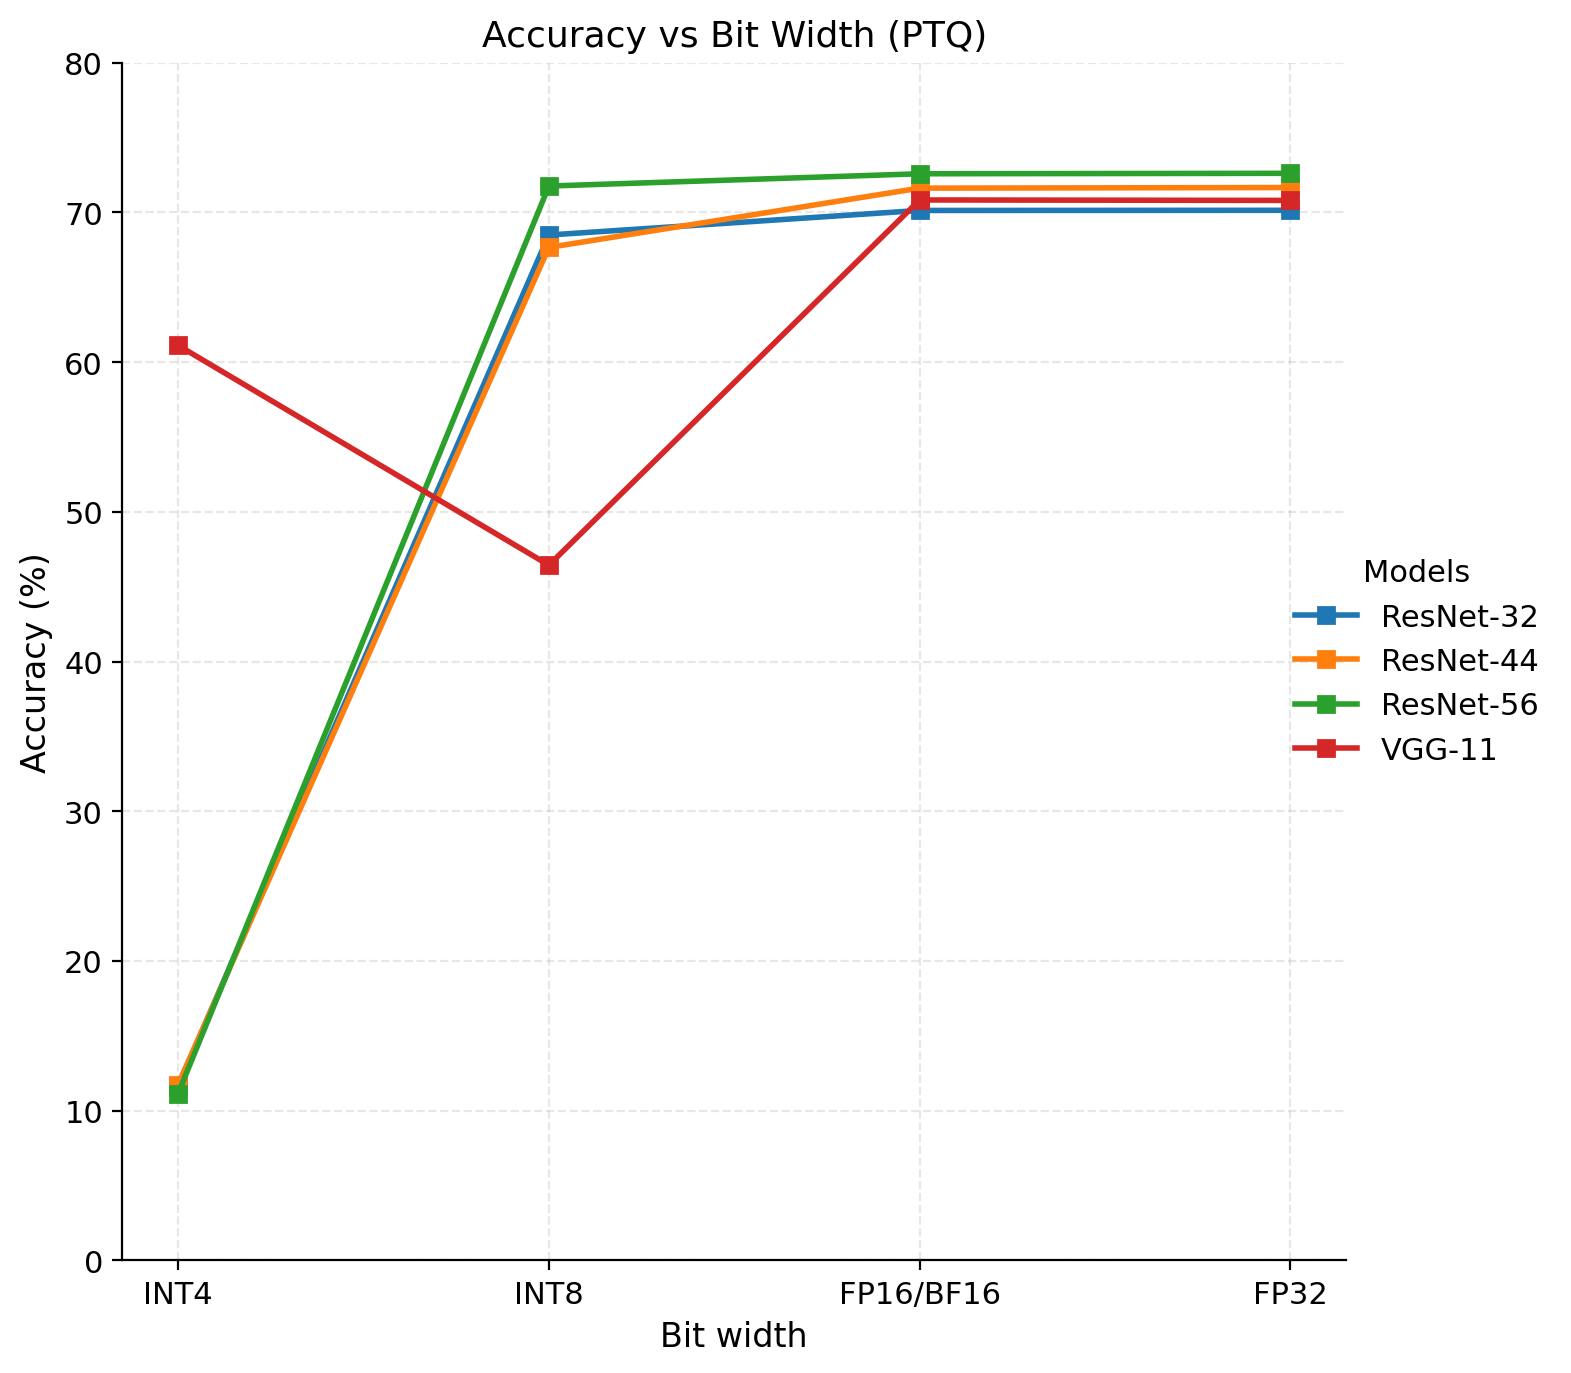

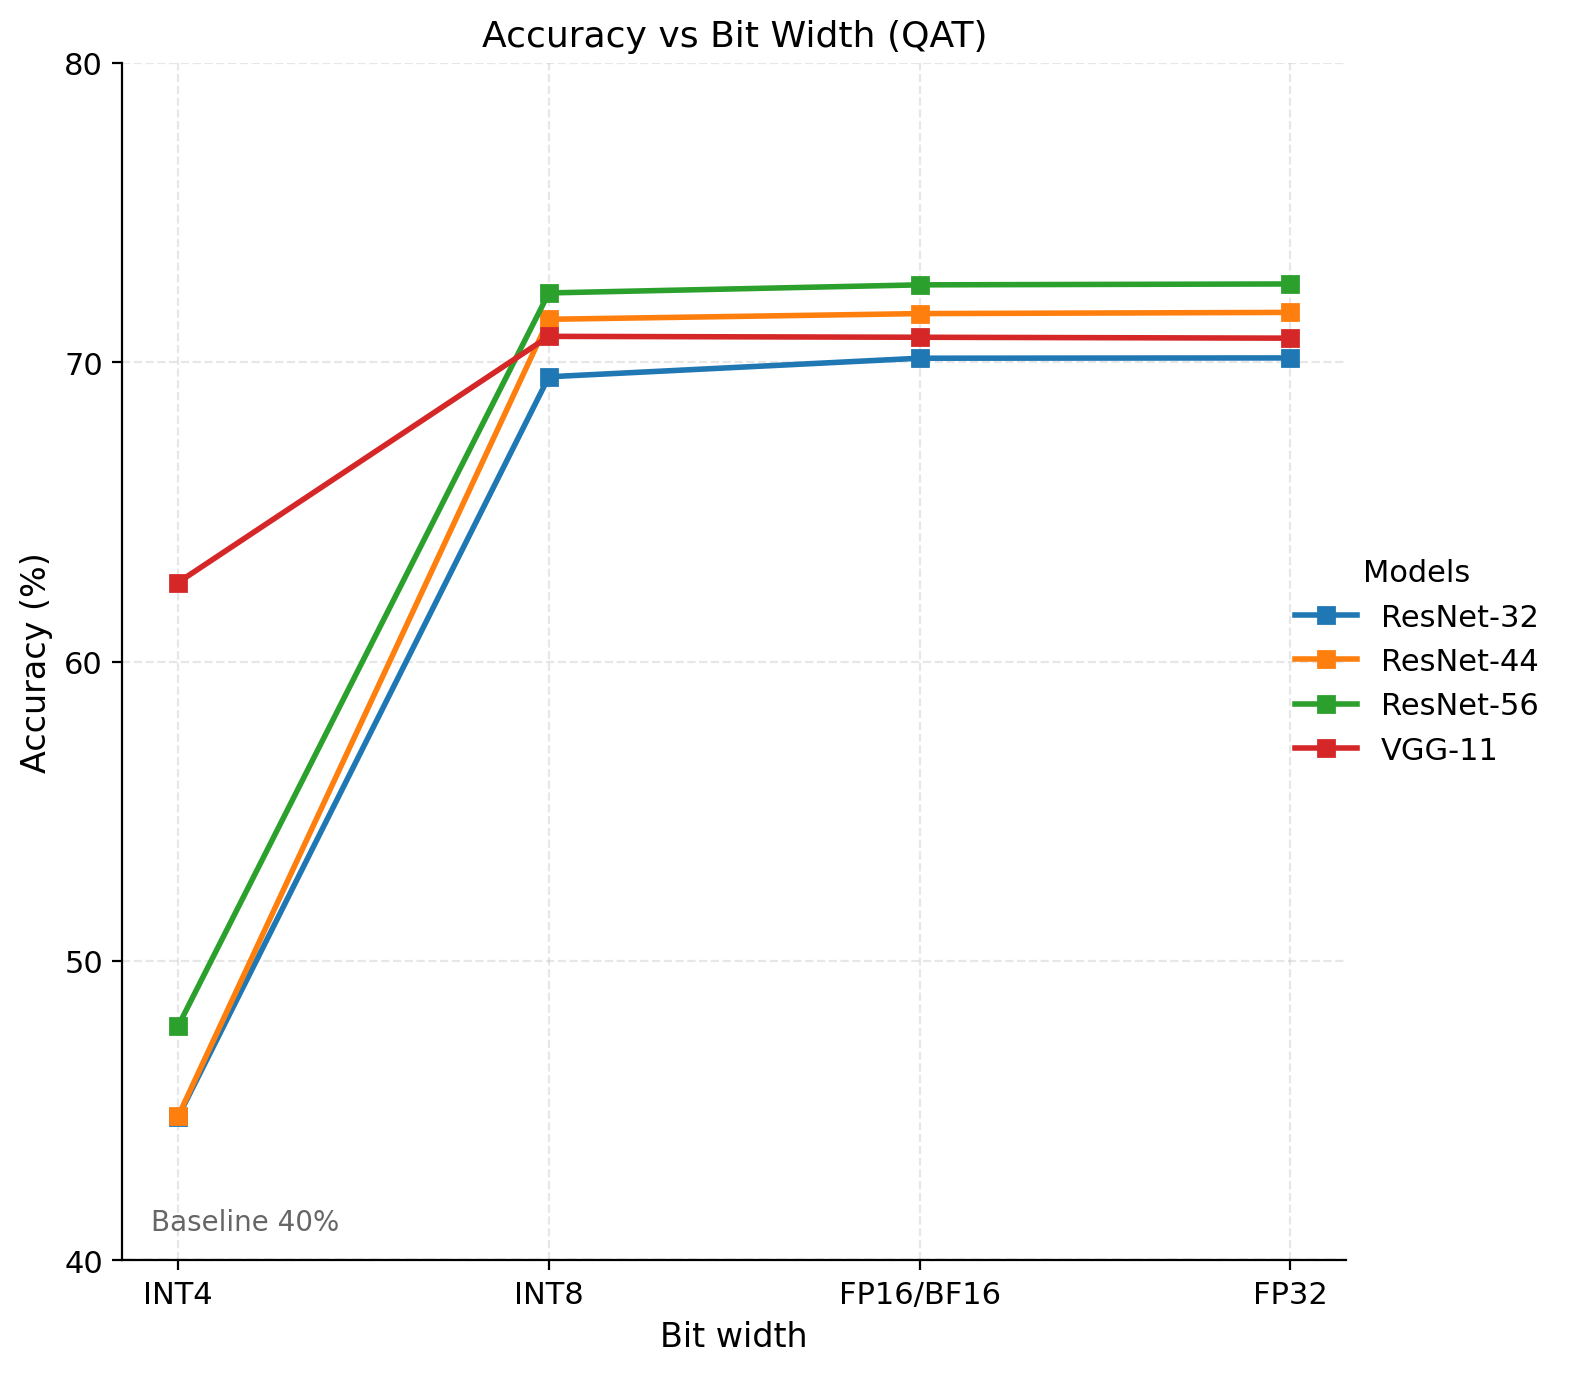

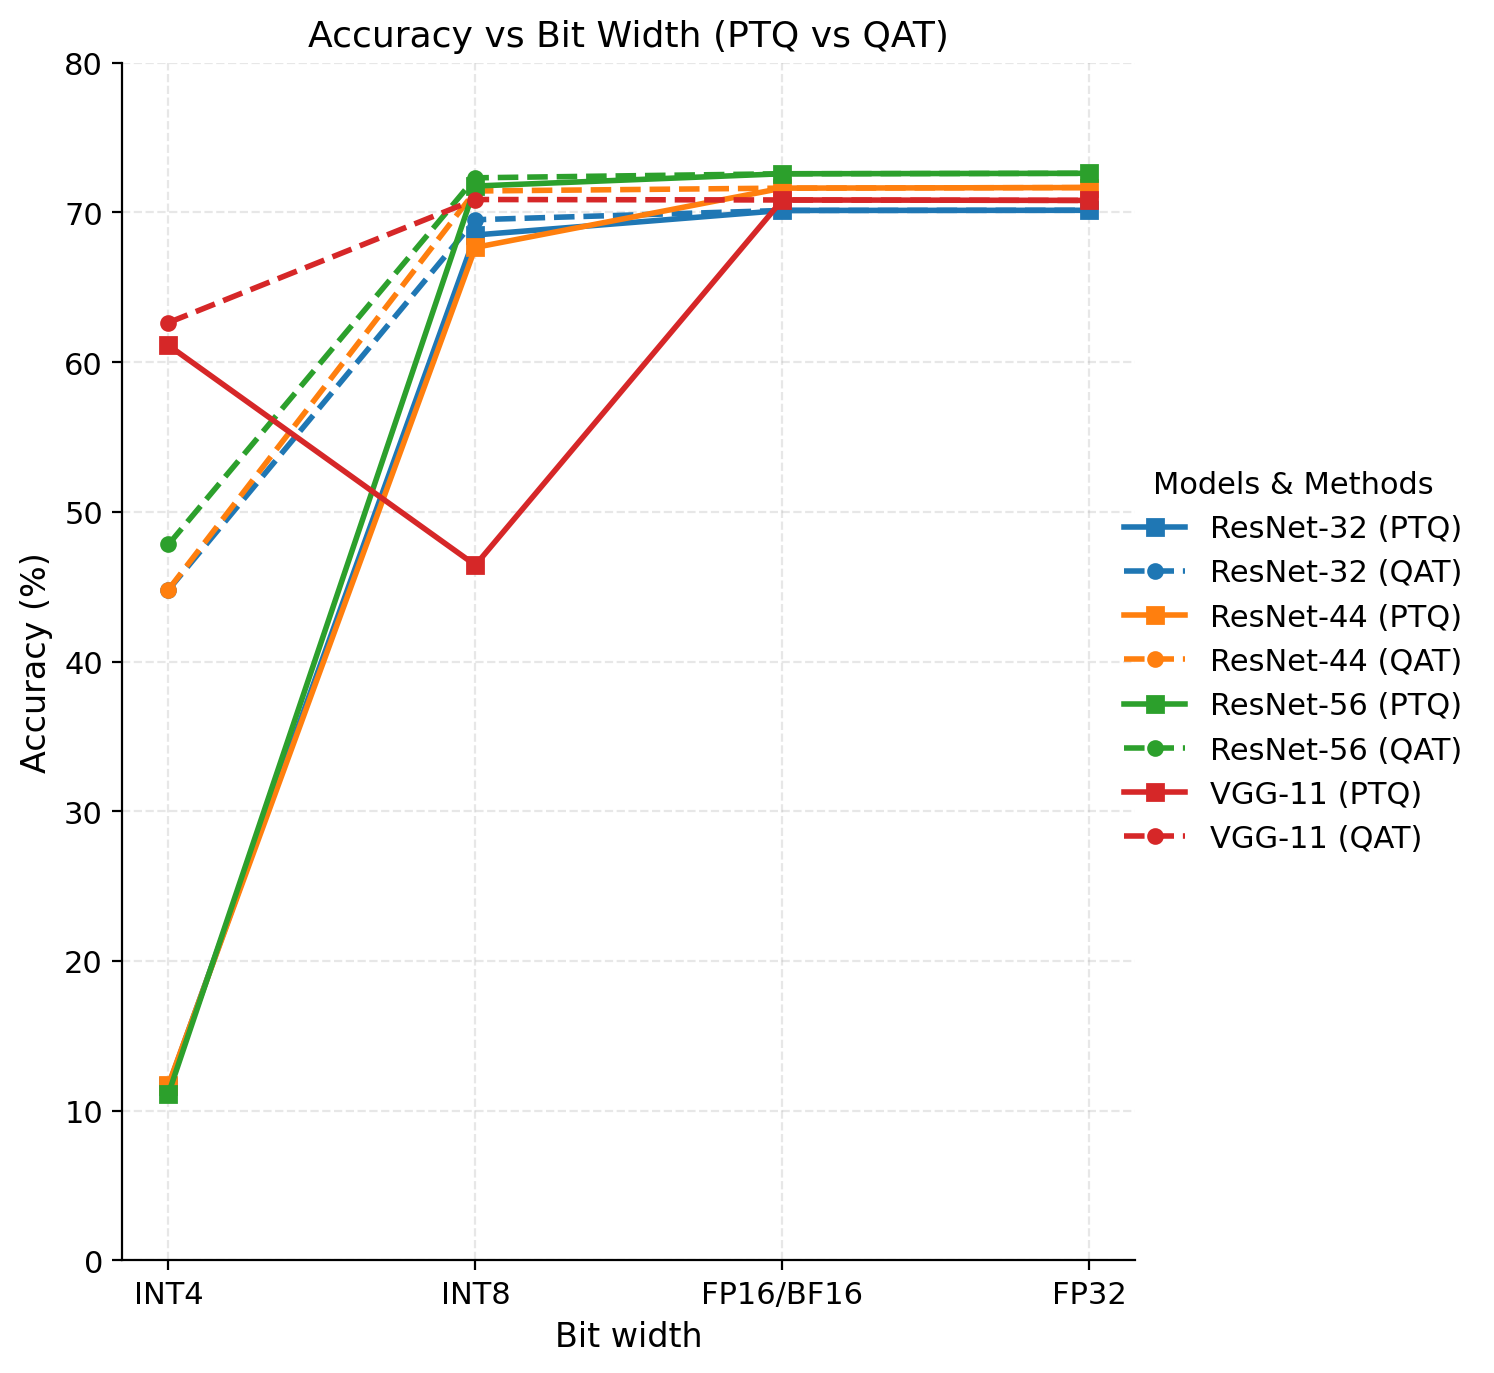

In [5]:
# =============================================================================
# ACCURACY vs BIT-WIDTH (PTQ & QAT) — SEPARATE ROWS + COMBINED VIEW
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# ------------------ Data ------------------
models = ["ResNet-32", "ResNet-44", "ResNet-56", "VGG-11"]
acc = {
    "VGG-11":   {"FP32":70.80,"FP16":70.83,"BF16":70.73,
                 "INT8_PTQ":46.44,"INT4_PTQ":61.12,
                 "INT8_QAT":70.86,"INT4_QAT":62.64},
    "ResNet-32":{"FP32":70.14,"FP16":70.13,"BF16":70.19,
                 "INT8_PTQ":68.49,"INT4_PTQ":11.66,
                 "INT8_QAT":69.51,"INT4_QAT":44.79},
    "ResNet-44":{"FP32":71.66,"FP16":71.62,"BF16":71.55,
                 "INT8_PTQ":67.66,"INT4_PTQ":11.74,
                 "INT8_QAT":71.43,"INT4_QAT":44.81},
    "ResNet-56":{"FP32":72.61,"FP16":72.58,"BF16":72.42,
                 "INT8_PTQ":71.76,"INT4_PTQ":11.14,
                 "INT8_QAT":72.31,"INT4_QAT":47.82},
}
bitwidths = np.array([4, 8, 16, 32])
xlabels   = ["INT4", "INT8", "FP16/BF16", "FP32"]

colors = {
    "ResNet-32": "#1f77b4",
    "ResNet-44": "#ff7f0e",
    "ResNet-56": "#2ca02c",
    "VGG-11":    "#d62728",
}

plt.rcParams.update({
    "figure.dpi": 200, "savefig.dpi": 300,
    "font.size": 11, "axes.labelsize": 12, "axes.titlesize": 13,
    "axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.30,
    "axes.spines.top": False, "axes.spines.right": False,
})

# ------------------ Helper Functions ------------------
def curve(model, method):
    d = acc[model]
    if method == "PTQ":
        return [d["INT4_PTQ"], d["INT8_PTQ"], d["FP16"], d["FP32"]]
    return [d["INT4_QAT"], d["INT8_QAT"], d["FP16"], d["FP32"]]

def setup_axes(ax, title, ylim=(0, 80), major_step=10):
    ax.set_xscale("log", base=2)
    ax.set_xticks(bitwidths, xlabels)
    ax.set_ylim(*ylim)

    # Major ticks every 10%, no minor ticks
    ax.yaxis.set_major_locator(ticker.MultipleLocator(major_step))
    ax.yaxis.set_minor_locator(ticker.NullLocator())

    # Labels and title
    ax.set_xlabel("Bit width")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title(title)

line_kw = dict(ls="-", marker="s", lw=2.0, ms=6)

# ------------------ PTQ Plot ------------------
fig1, ax1 = plt.subplots(figsize=(8, 7))  # taller figure for more vertical spacing
setup_axes(ax1, "Accuracy vs Bit Width (PTQ)", ylim=(0, 80), major_step=10)

for m in models:
    ax1.plot(bitwidths, curve(m, "PTQ"), color=colors[m], label=m, **line_kw)

ax1.legend(title="Models", frameon=False, loc="center right", bbox_to_anchor=(1.18, 0.5))
fig1.tight_layout()
fig1.savefig("acc_vs_bitwidth_PTQ_row.png")

# ------------------ QAT Plot ------------------
fig2, ax2 = plt.subplots(figsize=(8, 7))
setup_axes(ax2, "Accuracy vs Bit Width (QAT)", ylim=(40, 80), major_step=10)

for m in models:
    ax2.plot(bitwidths, curve(m, "QAT"), color=colors[m], label=m, **line_kw)

# Draw baseline at 40% with label
ax2.axhline(y=40, color="#888888", lw=1.2, ls="--", alpha=0.7)
ax2.text(3.8, 40.8, "Baseline 40%", color="#666666", fontsize=10, va="bottom", ha="left")

ax2.legend(title="Models", frameon=False, loc="center right", bbox_to_anchor=(1.18, 0.5))
fig2.tight_layout()
fig2.savefig("acc_vs_bitwidth_QAT_row.png")

# ------------------ COMBINED PTQ + QAT Plot ------------------
fig3, ax3 = plt.subplots(figsize=(8, 7))
setup_axes(ax3, "Accuracy vs Bit Width (PTQ vs QAT)", ylim=(0, 80), major_step=10)

for m in models:
    # PTQ (solid)
    ax3.plot(bitwidths, curve(m, "PTQ"), color=colors[m],
             ls="-", marker="s", lw=2.0, ms=6, label=f"{m} (PTQ)")
    # QAT (dashed)
    ax3.plot(bitwidths, curve(m, "QAT"), color=colors[m],
             ls="--", marker="o", lw=2.0, ms=5, label=f"{m} (QAT)")

ax3.legend(title="Models & Methods", frameon=False, loc="center right", bbox_to_anchor=(1.35, 0.5))
fig3.tight_layout()
fig3.savefig("acc_vs_bitwidth_combined.png")

print("Saved:")
print("  acc_vs_bitwidth_PTQ_row.png")
print("  acc_vs_bitwidth_QAT_row.png")
print("  acc_vs_bitwidth_combined.png")


In [13]:
import copy
import time
import torch
import torchvision
import torchvision.transforms as transforms

# ---------- setup ----------
device = torch.device("cpu")  # use torch.device, not string
print("Device:", device)

# ---------- data ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 stats
])
testset = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# ---------- model (FP32 baseline) ----------
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True).to(device).eval()

# ---------- evaluation ----------
@torch.no_grad()
def evaluate(model, loader):
    model_dtype = next(model.parameters()).dtype
    correct, total = 0, 0
    for x, y in loader:
        x = x.to(device=device, dtype=model_dtype, non_blocking=True)
        y = y.to(device=device, non_blocking=True)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

# ---------- model size ----------
def model_size_mb(model):
    total_bits = sum(p.numel() * p.element_size() * 8 for p in model.parameters())
    return total_bits / (8 * 1024 * 1024)  # bytes → MB

# ---------- inference latency ----------
@torch.no_grad()
def measure_latency(model, device, input_shape=(1, 3, 32, 32), warmup=20, runs=100):
    model.eval()
    x = torch.randn(input_shape, device=device, dtype=next(model.parameters()).dtype)

    # Warmup
    for _ in range(warmup):
        _ = model(x)
        if device.type == "cuda":
            torch.cuda.synchronize()

    # Measure
    start = time.perf_counter()
    for _ in range(runs):
        _ = model(x)
        if device.type == "cuda":
            torch.cuda.synchronize()
    end = time.perf_counter()

    latency_ms = (end - start) / runs * 1000
    return latency_ms

# ---------- FP32 metrics ----------
print("\n=== FP32 MODEL ===")
acc_fp32 = evaluate(model_fp32, testloader)
size_fp32 = model_size_mb(model_fp32)
latency_fp32 = measure_latency(model_fp32, device)
print(f"Accuracy      : {acc_fp32:.2f}%")
print(f"Model size    : {size_fp32:.2f} MB")
print(f"Latency       : {latency_fp32:.2f} ms/sample")

# ---------- BF16 metrics ----------
print("\n=== BF16 MODEL ===")
model_bf16 = copy.deepcopy(model_fp32).to(torch.bfloat16).eval()
acc_bf16 = evaluate(model_bf16, testloader)
size_bf16 = model_size_mb(model_bf16)
latency_bf16 = measure_latency(model_bf16, device)
print(f"Accuracy      : {acc_bf16:.2f}%")
print(f"Model size    : {size_bf16:.2f} MB")
print(f"Latency       : {latency_bf16:.2f} ms/sample")

# ---------- compression summary ----------
compression_ratio = size_fp32 / size_bf16
space_saved = (1 - size_bf16 / size_fp32) * 100
speedup = latency_fp32 / latency_bf16

print("\n=== COMPARISON ===")
print(f"Compression Ratio (BF16 vs FP32): {compression_ratio:.2f}x smaller")
print(f"Space Saved                      : {space_saved:.1f}%")
print(f"Speedup (Latency FP32/BF16)      : {speedup:.2f}x faster")

print("\nAnalysis complete.")


Device: cpu

=== FP32 MODEL ===


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Accuracy      : 70.80%
Model size    : 37.39 MB
Latency       : 6.83 ms/sample

=== BF16 MODEL ===
Accuracy      : 70.72%
Model size    : 18.70 MB
Latency       : 10.10 ms/sample

=== COMPARISON ===
Compression Ratio (BF16 vs FP32): 2.00x smaller
Space Saved                      : 50.0%
Speedup (Latency FP32/BF16)      : 0.68x faster

Analysis complete.


In [7]:
# =============================================================================
# MIXED-PRECISION (BF16 first/last + INT8 middle via FX-PTQ) — FULL METRICS
# =============================================================================
import os, copy, time, tempfile, collections
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

# -------------------- Setup --------------------
torch.backends.quantized.engine = "fbgemm"   # INT8 backend (CPU)
device = torch.device("cpu")                  # torch.ao quant runs on CPU
HIGH_DTYPE = torch.bfloat16                   # robust on CPU; (use float16 if CUDA)
print("Device:", device)
print("High-precision dtype for first/last:", HIGH_DTYPE)

# -------------------- Data --------------------
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_test = transforms.Compose([transforms.ToTensor(), normalize])
testset = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# -------------------- Baseline FP32 --------------------
print("\nLoading FP32 baseline (VGG-11 CIFAR-100)...")
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn",
                            pretrained=True).to(device).eval()

def evaluate(model: nn.Module, loader) -> float:
    correct = total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)  # AO graphs insert quantize nodes internally
            y = y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

def measure_latency(model: nn.Module, runs=200, warmup=30, input_shape=(1,3,32,32)) -> float:
    model.eval()
    x = torch.randn(input_shape, device=device, dtype=torch.float32)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(x)
        start = time.perf_counter()
        for _ in range(runs):
            _ = model(x)
        end = time.perf_counter()
    return (end - start) / runs * 1000.0  # ms

def save_size_mb(model: nn.Module, fname: str) -> float:
    tmp = os.path.join(tempfile.gettempdir(), fname)
    torch.save(model.state_dict(), tmp)
    sz = os.path.getsize(tmp) / (1024 * 1024)   # MiB
    try: os.remove(tmp)
    except OSError: pass
    return sz

def bits_to_mib_mbit(total_bits: int):
    mib = total_bits / (8 * 1024 * 1024)
    mbit = total_bits / (1024 * 1024)
    return mib, mbit

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

def find_first_conv_and_last_linear(model: nn.Module):
    first_conv, last_linear = None, None
    for name, m in model.named_modules():
        if isinstance(m, nn.Conv2d) and first_conv is None:
            first_conv = name
        if isinstance(m, nn.Linear):
            last_linear = name
    if first_conv is None or last_linear is None:
        raise RuntimeError("Could not locate first Conv2d or last Linear.")
    return first_conv, last_linear

def param_counts_split(model: nn.Module, keep_paths: set[str]):
    keep, rest = 0, 0
    for name, p in model.named_parameters():
        if any(name.startswith(path + ".") or name == path for path in keep_paths):
            keep += p.numel()
        else:
            rest += p.numel()
    return keep, rest

# ----- FP32 baseline metrics -----
print("\n=== FP32 BASELINE METRICS ===")
acc_fp32 = evaluate(model_fp32, testloader)
lat_fp32 = measure_latency(model_fp32)
total_params = count_params(model_fp32)
fp32_bits = total_params * 32
fp32_mib, fp32_mbit = bits_to_mib_mbit(fp32_bits)
fp32_ckpt_mib = save_size_mb(model_fp32, "vgg11_fp32_sd.pt")
print(f"Accuracy         : {acc_fp32:.2f}%")
print(f"Theoretical size : {fp32_mib:.2f} MiB  |  {fp32_mbit:.3f} Mbit")
print(f"Serialized size  : {fp32_ckpt_mib:.2f} MiB")
print(f"Latency          : {lat_fp32:.2f} ms/sample")

# -------------------- Build Mixed-Precision (BF16 first/last + INT8 middle) --------------------
# 1) INT8 PTQ config (remove unsupported kwargs)
act_obs = MinMaxObserver.with_args(
    dtype=torch.quint8, qscheme=torch.per_tensor_affine,
    quant_min=0, quant_max=255
)
wgt_obs = PerChannelMinMaxObserver.with_args(
    dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
    ch_axis=0, quant_min=-128, quant_max=127
)
int8_qconfig = tq.QConfig(activation=act_obs, weight=wgt_obs)

# 2) keep first conv & last linear in float during convert_fx
first_conv_path, last_linear_path = find_first_conv_and_last_linear(model_fp32)
print("\nIdentified paths:")
print("  first conv :", first_conv_path)
print("  last linear:", last_linear_path)

qmap = QConfigMapping().set_global(int8_qconfig)
qmap = qmap.set_module_name(first_conv_path, None)
qmap = qmap.set_module_name(last_linear_path, None)

example_inputs = (torch.randn(1, 3, 32, 32),)
prepared = prepare_fx(model_fp32, qmap, example_inputs=example_inputs)

print("Calibrating (using test stream as representative)...")
with torch.inference_mode():
    for x, _ in testloader:
        _ = prepared(x.to(device, dtype=torch.float32))

print("Converting to INT8 (first/last kept float)...")
mixed_model = convert_fx(prepared).eval()

# 3) Wrap first/last with BF16 bridges
class DTypeBridge(nn.Module):
    """Run inner module in HIGH_DTYPE, expose float32 interface to graph."""
    def __init__(self, mod: nn.Module, high_dtype: torch.dtype):
        super().__init__()
        self.mod = copy.deepcopy(mod).to(high_dtype)
        self.high_dtype = high_dtype
    def forward(self, x):
        return self.mod(x.to(self.high_dtype)).to(torch.float32)

def get_submodule(model: nn.Module, dotted_path: str) -> nn.Module:
    return model.get_submodule(dotted_path)

def set_submodule(model: nn.Module, dotted_path: str, new_module: nn.Module):
    parent_path, _, leaf = dotted_path.rpartition(".")
    parent = model if parent_path == "" else model.get_submodule(parent_path)
    setattr(parent, leaf, new_module)

orig_first = get_submodule(mixed_model, first_conv_path)
orig_last  = get_submodule(mixed_model, last_linear_path)
set_submodule(mixed_model, first_conv_path, DTypeBridge(orig_first, HIGH_DTYPE))
set_submodule(mixed_model, last_linear_path,  DTypeBridge(orig_last,  HIGH_DTYPE))
print("Wrapped first/last with dtype bridges.")

# -------------------- Mixed model metrics --------------------
print("\n=== MIXED-PRECISION METRICS (BF16 first/last + INT8 middle) ===")
acc_mixed = evaluate(mixed_model, testloader)
lat_mixed = measure_latency(mixed_model)

# Theoretical size: first/last at 16 bits, rest at 8 bits (counted on the FP32 topology)
keep_paths = {first_conv_path, last_linear_path}
keep_cnt, rest_cnt = param_counts_split(model_fp32, keep_paths)
mixed_bits = keep_cnt * 16 + rest_cnt * 8
mixed_mib, mixed_mbit = bits_to_mib_mbit(mixed_bits)

mixed_ckpt_mib = save_size_mb(mixed_model, "vgg11_mixed_sd.pt")

print(f"Accuracy           : {acc_mixed:.2f}%")
print(f"Theoretical size   : {mixed_mib:.2f} MiB  |  {mixed_mbit:.3f} Mbit")
print(f"Serialized size    : {mixed_ckpt_mib:.2f} MiB")
print(f"Latency            : {lat_mixed:.2f} ms/sample")

# -------------------- Comparative summary (vs FP32) --------------------
def pct_saved(a, b): return (1.0 - (b / a)) * 100.0

print("\n=== COMPARISON vs FP32 (Theoretical) ===")
print(f"Compression Ratio  : {fp32_mib / mixed_mib:.2f}x smaller")
print(f"Space Saved        : {pct_saved(fp32_mib, mixed_mib):.1f}%")
print(f"Speedup (Latency)  : {lat_fp32 / lat_mixed:.2f}x faster")

print("\n=== COMPARISON vs FP32 (Serialized checkpoint) ===")
print(f"Compression Ratio  : {fp32_ckpt_mib / mixed_ckpt_mib:.2f}x smaller")
print(f"Space Saved        : {pct_saved(fp32_ckpt_mib, mixed_ckpt_mib):.1f}%")

print("\nDone.")


Device: cpu
High-precision dtype for first/last: torch.bfloat16

Loading FP32 baseline (VGG-11 CIFAR-100)...

=== FP32 BASELINE METRICS ===


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Accuracy         : 70.80%
Theoretical size : 37.39 MiB  |  299.151 Mbit
Serialized size  : 37.43 MiB
Latency          : 6.63 ms/sample

Identified paths:
  first conv : features.0
  last linear: classifier.6
Calibrating (using test stream as representative)...
Converting to INT8 (first/last kept float)...
Wrapped first/last with dtype bridges.

=== MIXED-PRECISION METRICS (BF16 first/last + INT8 middle) ===
Accuracy           : 70.92%
Theoretical size   : 9.40 MiB  |  75.193 Mbit
Serialized size    : 9.48 MiB
Latency            : 3.51 ms/sample

=== COMPARISON vs FP32 (Theoretical) ===
Compression Ratio  : 3.98x smaller
Space Saved        : 74.9%
Speedup (Latency)  : 1.89x faster

=== COMPARISON vs FP32 (Serialized checkpoint) ===
Compression Ratio  : 3.95x smaller
Space Saved        : 74.7%

Done.


In [4]:
# ============================================================
# HAWQ-V2 Layer Ranking by Average Hessian Trace (PyTorch)
# Downscaled + Progress Tracking + Human-Readable Layer Names
# ============================================================

import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# -------------------- Settings --------------------
device = torch.device("cpu")
BATCH_SIZE_CALIB   = 64
NUM_CALIB_BATCHES  = 4     # downscaled
NUM_PROBES_PER_TSR = 8     # downscaled
SEED               = 1337

g_cpu = torch.Generator(device="cpu").manual_seed(SEED)

# -------------------- Data --------------------
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx = transforms.Compose([transforms.ToTensor(), normalize])

calib_set = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx)
calib_loader = torch.utils.data.DataLoader(
    calib_set, batch_size=BATCH_SIZE_CALIB, shuffle=True,
    num_workers=2, pin_memory=True, drop_last=True
)

# -------------------- Model --------------------
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True)
model = model.to(device).eval()
criterion = nn.CrossEntropyLoss(reduction="mean")

# -------------------- Helpers --------------------
def rademacher_like(p: torch.Tensor, gen: torch.Generator) -> torch.Tensor:
    return torch.empty_like(p, device=p.device).bernoulli_(0.5, generator=gen).mul_(2.).add_(-1.)

def named_weight_tensors(m: nn.Module):
    """Yield (full_param_name, parameter) for weight tensors (ndim>=2)."""
    for name, p in m.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim < 2:           # skip biases / norm scales etc.
            continue
        yield name, p

def resolve_module(model: nn.Module, module_path: str) -> nn.Module:
    """
    Resolve a dotted/indexed path like 'features.0' or 'classifier.6' to the nn.Module object.
    """
    obj = model
    for part in module_path.split('.'):
        if part.isdigit():
            obj = obj[int(part)]
        else:
            obj = getattr(obj, part)
    return obj

def pretty_layer_name(model: nn.Module, full_param_name: str) -> str:
    """
    Build a human-readable label, e.g.,
      'Conv2d(3→64, k3, s1) [features.0]'
      'Linear(4096→100) [classifier.6]'
    """
    # strip last token ('weight') -> module path
    module_path = full_param_name.rsplit('.', 1)[0]
    mod = resolve_module(model, module_path)

    if isinstance(mod, nn.Conv2d):
        k = mod.kernel_size[0] if isinstance(mod.kernel_size, tuple) else mod.kernel_size
        s = mod.stride[0] if isinstance(mod.stride, tuple) else mod.stride
        return f"Conv2d({mod.in_channels}→{mod.out_channels}, k{k}, s{s}) [{module_path}]"
    elif isinstance(mod, nn.Linear):
        return f"Linear({mod.in_features}→{mod.out_features}) [{module_path}]"
    else:
        # Fallback (should not happen because we filtered to ndim>=2 weights)
        return f"{module_path}"

# -------------------- Hessian trace (layer-wise) --------------------
def estimate_layer_traces(model: nn.Module,
                          loader,
                          num_batches: int,
                          num_probes: int,
                          gen: torch.Generator):
    # Stable parameter lists + identity map
    all_params = [p for p in model.parameters() if p.requires_grad]
    param_to_idx = {id(p): i for i, p in enumerate(all_params)}

    named_weights = list(named_weight_tensors(model))
    sizes = {n: p.numel() for n, p in named_weights}

    accum_trace = {n: 0.0 for n, _ in named_weights}
    counts      = {n: 0   for n, _ in named_weights}

    # -------- Progress tracking --------
    total_probes = num_batches * len(named_weights) * num_probes
    done_probes  = 0
    report_every = max(1, total_probes // 20)  # ~5% increments
    print(f"Total HVP probes planned: {total_probes}")
    t_start = time.perf_counter()

    used_batches = 0
    for x, y in loader:
        if used_batches >= num_batches:
            break
        used_batches += 1

        x = x.to(device)
        y = y.to(device)

        # Forward + loss
        logits = model(x)
        loss = criterion(logits, y)

        # First-order grads (keep graph for HVPs)
        grads = torch.autograd.grad(loss, all_params, create_graph=True, retain_graph=True, allow_unused=False)

        # Zero template matching all_params
        zero_template = [torch.zeros_like(p, device=p.device) for p in all_params]

        # For each weight tensor (layer), estimate v^T H v
        for layer_name, W_i in named_weights:
            idx = param_to_idx[id(W_i)]

            vHv_sum = 0.0
            for _ in range(num_probes):
                v_list = list(zero_template)
                v_i = rademacher_like(W_i, gen)
                v_list[idx] = v_i

                # s = <grads, v>
                s_terms = [(g * v).sum() for g, v in zip(grads, v_list)]
                s = torch.stack(s_terms).sum()

                # Hv = ∇_θ s
                Hv = torch.autograd.grad(s, all_params, retain_graph=True, allow_unused=False)

                # v^T H v = <Hv, v>
                vHv = 0.0
                for h_comp, v_comp in zip(Hv, v_list):
                    if v_comp is not None:
                        vHv += (h_comp * v_comp).sum().item()
                vHv_sum += vHv

                # ---- progress update per probe ----
                done_probes += 1
                if (done_probes % report_every == 0) or (done_probes == total_probes):
                    pct = 100.0 * done_probes / total_probes
                    elapsed = time.perf_counter() - t_start
                    print(f"\rProgress: {pct:5.1f}%  "
                          f"({done_probes}/{total_probes})  "
                          f"Elapsed: {elapsed:6.1f}s", end="", flush=True)

            vHv_avg = vHv_sum / float(num_probes)
            accum_trace[layer_name] += vHv_avg
            counts[layer_name]      += 1

        # free per-batch graph
        del grads, loss, logits

    # final newline after progress line
    print()

    # Aggregate to per-layer metrics
    results = {}
    for n, _ in named_weights:
        tr = (accum_trace[n] / counts[n]) if counts[n] > 0 else 0.0
        numel = sizes[n]
        avg_tr = tr / float(numel) if numel > 0 else 0.0
        results[n] = {"trace": tr, "avg_trace_per_param": avg_tr, "numel": numel}
    return results

# -------------------- Run & Report --------------------
t0 = time.perf_counter()
layer_stats = estimate_layer_traces(
    model=model,
    loader=calib_loader,
    num_batches=NUM_CALIB_BATCHES,
    num_probes=NUM_PROBES_PER_TSR,
    gen=g_cpu
)
t1 = time.perf_counter()

# Build a mapping from raw parameter name to human-readable label once
pretty_name_map = {raw_name: pretty_layer_name(model, raw_name) for raw_name in layer_stats.keys()}

ranked = sorted(
    [(
        pretty_name_map[n],                # human-readable layer name
        layer_stats[n]["numel"],
        layer_stats[n]["trace"],
        layer_stats[n]["avg_trace_per_param"]
     ) for n in layer_stats.keys()],
    key=lambda t: t[3],
    reverse=True
)

header = f"{'Rank':>4}  {'Layer (human-readable)':<45}  {'#Params':>10}  {'Trace(H)':>14}  {'AvgTrace/Param':>16}"
print("\n=== HAWQ-V2 Layer Sensitivity Ranking (Avg Hessian Trace per Param) ===")
print(header)
print("-" * len(header))
for i, (pretty, numel, tr, avgtr) in enumerate(ranked, 1):
    print(f"{i:4d}  {pretty:<45}  {numel:10d}  {tr:14.6e}  {avgtr:16.6e}")

print(f"\nCalibration batches: {NUM_CALIB_BATCHES}  |  Probes/tensor: {NUM_PROBES_PER_TSR}")
print(f"Wall time: {t1 - t0:.1f}s")


Total HVP probes planned: 352


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Progress: 100.0%  (352/352)  Elapsed:  280.3s

=== HAWQ-V2 Layer Sensitivity Ranking (Avg Hessian Trace per Param) ===
Rank  Layer (human-readable)                            #Params        Trace(H)    AvgTrace/Param
-------------------------------------------------------------------------------------------------
   1  Conv2d(3→64, k3, s1) [features.0]                    1728    6.580518e+02      3.808170e-01
   2  Conv2d(64→128, k3, s1) [features.4]                 73728    1.542040e+03      2.091526e-02
   3  Conv2d(128→256, k3, s1) [features.8]               294912    1.679242e+03      5.694045e-03
   4  Conv2d(256→256, k3, s1) [features.11]              589824    1.572852e+03      2.666647e-03
   5  Conv2d(256→512, k3, s1) [features.15]             1179648    2.766633e+03      2.345304e-03
   6  Conv2d(512→512, k3, s1) [features.18]             2359296    3.169305e+03      1.343326e-03
   7  Linear(512→100) [classifier.6]                      51200    6.041955e+01      1.180069e-03

In [4]:
# ============================================================
# Mixed-Precision Quantization (BF16 / INT8 / INT4-emulated)
# Activations: INT8 throughout
# Model: VGG-11-BN (CIFAR-100)  — FX PTQ (FBGEMM)
# ============================================================

import os, time, tempfile, copy, collections
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# -------------------- Settings --------------------
torch.backends.quantized.engine = "fbgemm"   # CPU INT8 backend
device = torch.device("cpu")
HIGH_DTYPE = torch.bfloat16
BATCH_SIZE = 256

# Optional: if you have 'layer_stats' in your session, the script will use it to derive the map.
# Otherwise it will fall back to a reasonable default for this VGG-11-BN instance.
try:
    _HAS_LAYER_STATS = isinstance(layer_stats, dict) and len(layer_stats) > 0
except NameError:
    _HAS_LAYER_STATS = False

# -------------------- Data --------------------
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx)

def make_balanced_subset(dataset, num_classes=100, per_class=10):
    targets = dataset.targets if hasattr(dataset, "targets") else dataset.labels
    buckets = [[] for _ in range(num_classes)]
    for idx, y in enumerate(targets):
        if len(buckets[y]) < per_class:
            buckets[y].append(idx)
        if all(len(b) >= per_class for b in buckets):
            break
    idxs = [i for b in buckets for i in b]
    return torch.utils.data.Subset(dataset, idxs)

calib_subset = make_balanced_subset(trainset, per_class=10)
calibloader = torch.utils.data.DataLoader(calib_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,      batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# -------------------- Load FP32 model --------------------
print("Loading FP32 model...")
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn",
                            pretrained=True).to(device).eval()

# -------------------- Utilities --------------------
def evaluate(model: nn.Module, loader) -> float:
    correct = total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)  # quant ops are in-graph
            y = y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

def measure_latency(model: nn.Module, runs=200, warmup=30, input_shape=(1,3,32,32)) -> float:
    model.eval()
    x = torch.randn(input_shape, device=device, dtype=torch.float32)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(x)
        start = time.perf_counter()
        for _ in range(runs):
            _ = model(x)
        end = time.perf_counter()
    return (end - start) / runs * 1000.0  # ms

def get_first_conv_path_and_all_linear_conv(model: nn.Module):
    first_conv = None
    conv_or_linear_paths = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            conv_or_linear_paths.append(name)
            if first_conv is None and isinstance(m, nn.Conv2d):
                first_conv = name
    if first_conv is None:
        raise RuntimeError("Could not locate first Conv2d.")
    return first_conv, conv_or_linear_paths

def set_submodule(model: nn.Module, dotted_path: str, new_module: nn.Module):
    parent_path, _, leaf = dotted_path.rpartition(".")
    parent = model if parent_path == "" else model.get_submodule(parent_path)
    setattr(parent, leaf, new_module)

class DTypeBridge(nn.Module):
    """Run inner module in HIGH_DTYPE; expose float32 interface to the graph."""
    def __init__(self, mod: nn.Module, high_dtype: torch.dtype):
        super().__init__()
        self.mod = copy.deepcopy(mod).to(high_dtype)
        self.high_dtype = high_dtype
    def forward(self, x):
        return self.mod(x.to(self.high_dtype)).to(torch.float32)

# -------------------- Build the per-layer precision map --------------------
# Policy:
#   - FP16: first Conv2d
#   - INT8: avg_trace in [1e-3, 1e-1)  (also includes 1.1e-3, etc.)
#   - INT4: avg_trace <= 1e-4 (and 1e-5)
#
# If layer_stats are present, derive automatically. Else fall back to representative names.

first_conv_path, all_quantizable_paths = get_first_conv_path_and_all_linear_conv(model_fp32)

fp16_paths = { first_conv_path }
int4_paths = set()
int8_paths = set()

if _HAS_LAYER_STATS:
    # layer_stats keys are parameter names like "features.25.weight" -> map to module path "features.25"
    def param_to_module_path(pname: str) -> str:
        return pname.rsplit('.', 1)[0]

    # thresholds
    def assign(avgtr: float) -> str:
        if avgtr >= 1e-1:
            return "fp16"
        elif 1e-3 <= avgtr < 1e-1:
            return "int8"
        else:
            # <= 1e-4 (or 1e-5): int4
            return "int4"

    for param_name, stats in layer_stats.items():
        if not param_name.endswith(".weight"):
            continue
        mod_path = param_to_module_path(param_name)
        # Only consider Conv/Linear modules we can quantize
        try:
            m = model_fp32.get_submodule(mod_path)
        except AttributeError:
            continue
        if not isinstance(m, (nn.Conv2d, nn.Linear)):
            continue
        avgtr = float(stats["avg_trace_per_param"])
        role = assign(avgtr)
        if role == "fp16":
            fp16_paths.add(mod_path)
        elif role == "int8":
            int8_paths.add(mod_path)
        elif role == "int4":
            int4_paths.add(mod_path)
else:
    # Fallback to the measured names from your ranking
    # INT4-emulated weights:
    int4_paths.update({"features.25", "classifier.0", "classifier.3"})
    # INT8: all other Conv/Linear except FP16/INT4
    for p in all_quantizable_paths:
        if p not in fp16_paths and p not in int4_paths:
            int8_paths.add(p)

# Ensure disjointness
int8_paths.difference_update(fp16_paths)
int4_paths.difference_update(fp16_paths)
int4_paths.difference_update(int8_paths)

print("\nSelected precision per module:")
print("  FP16 :", sorted(fp16_paths))
print("  INT8 :", sorted(int8_paths)[:5], ("... (+%d more)" % (max(0, len(int8_paths)-5))) if len(int8_paths)>5 else "")
print("  INT4 :", sorted(int4_paths))

# -------------------- FX PTQ config (INT8 activations everywhere) --------------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

# Activations: INT8, per-tensor affine [0..255]
act_obs_int8 = MinMaxObserver.with_args(
    dtype=torch.quint8, qscheme=torch.per_tensor_affine,
    quant_min=0, quant_max=255
)

# Weights:
#   - INT8 default: symmetric per-channel [-128..127]
wgt_obs_int8 = PerChannelMinMaxObserver.with_args(
    dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
    ch_axis=0, quant_min=-128, quant_max=127
)
#   - INT4-emulated: symmetric per-channel [-8..7] (kernels still int8)
wgt_obs_int4 = PerChannelMinMaxObserver.with_args(
    dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
    ch_axis=0, quant_min=-8, quant_max=7
)

qconfig_int8 = tq.QConfig(activation=act_obs_int8, weight=wgt_obs_int8)
qconfig_int4 = tq.QConfig(activation=act_obs_int8, weight=wgt_obs_int4)

# Build name-based QConfig mapping:
qmap = QConfigMapping().set_global(qconfig_int8)

# FP16 modules: keep them float (no quant) during convert; we’ll wrap them after conversion
for path in fp16_paths:
    qmap = qmap.set_module_name(path, None)

# INT4-emulated modules: override with 4-bit weight observer (activations remain int8)
for path in int4_paths:
    qmap = qmap.set_module_name(path, qconfig_int4)

# -------------------- Prepare -> Calibrate -> Convert --------------------
example_inputs = (torch.randn(1, 3, 32, 32),)
print("\nPreparing FX graph...")
prepared = prepare_fx(model_fp32, qmap, example_inputs=example_inputs)

print("Calibrating...")
with torch.inference_mode():
    for x, _ in calibloader:
        _ = prepared(x.to(device, dtype=torch.float32))

print("Converting...")
mixed_model = convert_fx(prepared).eval()

# Wrap FP16 modules with dtype bridges (run in FP16, expose FP32 so downstream INT8 activations still apply)
for path in fp16_paths:
    orig = mixed_model.get_submodule(path)
    set_submodule(mixed_model, path, DTypeBridge(orig, HIGH_DTYPE))

# -------------------- Verification --------------------
def summarize_quantization(gm: torch.fx.GraphModule):
    gm.graph.lint(); gm.recompile()
    mod_counts = collections.Counter()
    q_input_calls = 0
    dq_output_calls = 0
    for name, m in gm.named_modules():
        modname = m.__class__.__name__
        modpath = m.__class__.__module__
        if modpath.startswith("torch.ao.nn.quantized"):
            mod_counts[modname] += 1
    for n in gm.graph.nodes:
        if n.op == "call_function" and n.target is torch.quantize_per_tensor:
            q_input_calls += 1
        if n.op == "call_method" and n.target == "dequantize":
            dq_output_calls += 1
    print("\n=== Quantization verification ===")
    if mod_counts:
        print("Quantized modules present:")
        for k, v in mod_counts.most_common():
            print(f"  {k}: {v}")
    else:
        print("No quantized modules detected via module scan.")
    print(f"Input quantize_per_tensor nodes: {q_input_calls}")
    print(f"Output .dequantize() nodes      : {dq_output_calls}")
    print("STATUS:", "QUANTIZED" if (mod_counts or (q_input_calls>0 and dq_output_calls>0)) else "NOT QUANTIZED")

summarize_quantization(mixed_model)

# -------------------- Metrics --------------------
print("\nEvaluating mixed-precision model (FP16 / INT8 / INT4-emul, INT8 activations)...")
acc_mixed = evaluate(mixed_model, testloader)
lat_mixed = measure_latency(mixed_model)

print(f"\nAccuracy : {acc_mixed:.2f}%")
print(f"Latency  : {lat_mixed:.2f} ms/sample")

print("\nDone.")


Loading FP32 model...

Selected precision per module:
  FP16 : ['features.0']
  INT8 : ['classifier.6', 'features.11', 'features.15', 'features.18', 'features.22'] ... (+2 more)
  INT4 : ['classifier.0', 'classifier.3', 'features.25']

Preparing FX graph...
Calibrating...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Converting...

=== Quantization verification ===
Quantized modules present:
  LinearPackedParams: 3
  Dropout: 2
  Linear: 1
Input quantize_per_tensor nodes: 1
Output .dequantize() nodes      : 1
STATUS: QUANTIZED

Evaluating mixed-precision model (FP16 / INT8 / INT4-emul, INT8 activations)...

Accuracy : 70.58%
Latency  : 2.81 ms/sample

Done.


In [8]:
# ============================================================
# THEORETICAL & SERIALIZED SIZE FOR ADAPTIVE MIXED-PRECISION
# - Counts bits from the FP32 topology using your path sets:
#     fp16_paths, int8_paths, int4_paths
# - Treats INT4-emulated layers as true 4-bit for theory
# - Bias handling: int8/int4 layers -> 32-bit bias (standard)
# ============================================================

import os, tempfile, collections, torch
from typing import Tuple

# ---- knobs ----
ASSUME_INTX_BIAS_INT32 = True   # int8/int4 bias counted as 32-bit (common)
FP16_BIAS_BITS = 16

def _bits_to_sizes(total_bits: int) -> Tuple[float, float]:
    mib  = total_bits / (8 * 1024 * 1024)
    mbit = total_bits / (1024 * 1024)
    return mib, mbit

def _parent_module_path(param_name: str) -> str:
    # "features.25.weight" -> "features.25"
    return param_name.rsplit('.', 1)[0]

def _layer_bitwidth(mod_path: str, is_bias: bool) -> int:
    if mod_path in fp16_paths:
        return FP16_BIAS_BITS if is_bias else 16
    if mod_path in int4_paths:
        return 32 if (is_bias and ASSUME_INTX_BIAS_INT32) else 4
    # default to INT8 for anything else
    return 32 if (is_bias and ASSUME_INTX_BIAS_INT32) else 8

def theoretical_bits_from_fp32(fp32_model: torch.nn.Module) -> Tuple[int, dict]:
    """Sum bits layer-wise from the FP32 graph using assigned precisions."""
    totals = collections.Counter()
    total_bits = 0
    for name, p in fp32_model.named_parameters():
        mod_path = _parent_module_path(name)
        is_bias  = name.endswith(".bias")
        bits_per_elem = _layer_bitwidth(mod_path, is_bias)
        n = p.numel()
        total_bits += n * bits_per_elem
        key = ("FP16" if mod_path in fp16_paths else
               "INT4" if mod_path in int4_paths else
               "INT8")
        key += "_bias" if is_bias else "_weight"
        totals[key] += n * bits_per_elem
    return total_bits, totals

def serialized_size_mib(model: torch.nn.Module) -> float:
    """Save state_dict and measure actual checkpoint size."""
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pt") as tmp:
        torch.save(model.state_dict(), tmp.name)
        size_mib = os.path.getsize(tmp.name) / (1024 * 1024)
        path = tmp.name
    try:
        os.remove(path)
    except OSError:
        pass
    return size_mib

# ---- compute ----
theory_bits, breakdown = theoretical_bits_from_fp32(model_fp32)
theory_mib, theory_mbit = _bits_to_sizes(theory_bits)
ser_mib = serialized_size_mib(mixed_model)

# ---- report ----
print("\n=== MODEL SIZE REPORT: Mixed-Precision (FP16/INT8/INT4) ===")
print(f"Theoretical size : {theory_mib:.2f} MiB  |  {theory_mbit:.3f} Mbit")
print(f"Serialized size  : {ser_mib:.2f} MiB")

# Optional: show category breakdown
if breakdown:
    print("\nBreakdown (bits):")
    for k, v in sorted(breakdown.items()):
        mib, _ = _bits_to_sizes(v)
        print(f"  {k:12s} -> {v:,} bits  (~{mib:.2f} MiB)")



=== MODEL SIZE REPORT: Mixed-Precision (FP16/INT8/INT4) ===
Theoretical size : 7.99 MiB  |  63.952 Mbit
Serialized size  : 9.43 MiB

Breakdown (bits):
  FP16_bias    -> 1,024 bits  (~0.00 MiB)
  FP16_weight  -> 27,648 bits  (~0.00 MiB)
  INT4_bias    -> 49,152 bits  (~0.01 MiB)
  INT4_weight  -> 11,534,336 bits  (~1.38 MiB)
  INT8_bias    -> 160,896 bits  (~0.02 MiB)
  INT8_weight  -> 55,285,248 bits  (~6.59 MiB)


In [6]:
# ============================================================
# Mixed-Precision Quantization (INT8 / INT4-emulated only)
# Activations: INT8 throughout
# Model: VGG-11-BN (CIFAR-100) — FX PTQ (FBGEMM)
# NOTE: This is the same as your previous script except
#       FP16 layers are now treated as INT8 (no FP16 anywhere).
# ============================================================

import os, time, tempfile, copy, collections
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# -------------------- Settings --------------------
torch.backends.quantized.engine = "fbgemm"   # CPU INT8 backend
device = torch.device("cpu")
BATCH_SIZE = 256

# Optional: if you have 'layer_stats' in your session, the script will use it to derive the map.
# Otherwise it will fall back to a reasonable default for this VGG-11-BN instance.
try:
    _HAS_LAYER_STATS = isinstance(layer_stats, dict) and len(layer_stats) > 0
except NameError:
    _HAS_LAYER_STATS = False

# -------------------- Data --------------------
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx)

def make_balanced_subset(dataset, num_classes=100, per_class=10):
    targets = dataset.targets if hasattr(dataset, "targets") else dataset.labels
    buckets = [[] for _ in range(num_classes)]
    for idx, y in enumerate(targets):
        if len(buckets[y]) < per_class:
            buckets[y].append(idx)
        if all(len(b) >= per_class for b in buckets):
            break
    idxs = [i for b in buckets for i in b]
    return torch.utils.data.Subset(dataset, idxs)

calib_subset = make_balanced_subset(trainset, per_class=10)
calibloader = torch.utils.data.DataLoader(calib_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,      batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# -------------------- Load FP32 model --------------------
print("Loading FP32 model...")
model_fp32 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn",
                            pretrained=True).to(device).eval()

# -------------------- Utilities --------------------
def evaluate(model: nn.Module, loader) -> float:
    correct = total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)  # quant ops are in-graph
            y = y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

def measure_latency(model: nn.Module, runs=200, warmup=30, input_shape=(1,3,32,32)) -> float:
    model.eval()
    x = torch.randn(input_shape, device=device, dtype=torch.float32)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(x)
        start = time.perf_counter()
        for _ in range(runs):
            _ = model(x)
        end = time.perf_counter()
    return (end - start) / runs * 1000.0  # ms

def get_first_conv_path_and_all_linear_conv(model: nn.Module):
    first_conv = None
    conv_or_linear_paths = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            conv_or_linear_paths.append(name)
            if first_conv is None and isinstance(m, nn.Conv2d):
                first_conv = name
    if first_conv is None:
        raise RuntimeError("Could not locate first Conv2d.")
    return first_conv, conv_or_linear_paths

def set_submodule(model: nn.Module, dotted_path: str, new_module: nn.Module):
    parent_path, _, leaf = dotted_path.rpartition(".")
    parent = model if parent_path == "" else model.get_submodule(parent_path)
    setattr(parent, leaf, new_module)

# -------------------- Build the per-layer precision map --------------------
# Policy for this script:
#   - No FP16 anywhere. Treat previously-FP16 layers as INT8.
#   - INT8: default for all Conv/Linear.
#   - INT4-emulated (weights only): layers with very low curvature (<=1e-4) if layer_stats provided,
#     otherwise fall back to {"features.25", "classifier.0", "classifier.3"} as in your ranking.

first_conv_path, all_quantizable_paths = get_first_conv_path_and_all_linear_conv(model_fp32)

fp16_paths = set()   # <-- empty: FP16 removed
int4_paths = set()
int8_paths = set()

if _HAS_LAYER_STATS:
    def param_to_module_path(pname: str) -> str:
        return pname.rsplit('.', 1)[0]

    def assign(avgtr: float) -> str:
        # Original rule: >=1e-1 -> fp16, [1e-3,1e-1) -> int8, <=1e-4 -> int4
        # Here we *replace fp16 with int8*.
        if avgtr >= 1e-1:
            return "int8"   # replace fp16 with int8
        elif 1e-3 <= avgtr < 1e-1:
            return "int8"
        else:
            return "int4"

    for param_name, stats in layer_stats.items():
        if not param_name.endswith(".weight"):
            continue
        mod_path = param_to_module_path(param_name)
        try:
            m = model_fp32.get_submodule(mod_path)
        except AttributeError:
            continue
        if not isinstance(m, (nn.Conv2d, nn.Linear)):
            continue
        avgtr = float(stats["avg_trace_per_param"])
        role = assign(avgtr)
        if role == "int8":
            int8_paths.add(mod_path)
        elif role == "int4":
            int4_paths.add(mod_path)
else:
    # Fallback: use your measured low-sensitivity set for INT4; everything else INT8
    int4_paths.update({"features.25", "classifier.0", "classifier.3"})
    for p in all_quantizable_paths:
        if p not in int4_paths:
            int8_paths.add(p)

# Ensure disjointness (fp16_paths is empty)
int4_paths.difference_update(int8_paths)

print("\nSelected precision per module (FP16 removed):")
print("  INT8 :", sorted(int8_paths)[:8], ("... (+%d more)" % (max(0, len(int8_paths)-8))) if len(int8_paths)>8 else "")
print("  INT4 :", sorted(int4_paths))

# -------------------- FX PTQ config (INT8 activations everywhere) --------------------
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver

# Activations: INT8, per-tensor affine [0..255]
act_obs_int8 = MinMaxObserver.with_args(
    dtype=torch.quint8, qscheme=torch.per_tensor_affine,
    quant_min=0, quant_max=255
)

# Weights:
#   - INT8 default: symmetric per-channel [-128..127]
wgt_obs_int8 = PerChannelMinMaxObserver.with_args(
    dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
    ch_axis=0, quant_min=-128, quant_max=127
)
#   - INT4-emulated: symmetric per-channel [-8..7] (kernels still int8)
wgt_obs_int4 = PerChannelMinMaxObserver.with_args(
    dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
    ch_axis=0, quant_min=-8, quant_max=7
)

qconfig_int8 = tq.QConfig(activation=act_obs_int8, weight=wgt_obs_int8)
qconfig_int4 = tq.QConfig(activation=act_obs_int8, weight=wgt_obs_int4)

# Build name-based QConfig mapping:
qmap = QConfigMapping().set_global(qconfig_int8)

# INT4-emulated modules: override with 4-bit weight observer (activations remain int8)
for path in int4_paths:
    qmap = qmap.set_module_name(path, qconfig_int4)

# -------------------- Prepare -> Calibrate -> Convert --------------------
example_inputs = (torch.randn(1, 3, 32, 32),)
print("\nPreparing FX graph...")
prepared = prepare_fx(model_fp32, qmap, example_inputs=example_inputs)

print("Calibrating...")
with torch.inference_mode():
    for x, _ in calibloader:
        _ = prepared(x.to(device, dtype=torch.float32))

print("Converting...")
quant_model = convert_fx(prepared).eval()

# -------------------- Verification --------------------
def summarize_quantization(gm: torch.fx.GraphModule):
    gm.graph.lint(); gm.recompile()
    mod_counts = collections.Counter()
    q_input_calls = 0
    dq_output_calls = 0
    for name, m in gm.named_modules():
        modname = m.__class__.__name__
        modpath = m.__class__.__module__
        if modpath.startswith("torch.ao.nn.quantized"):
            mod_counts[modname] += 1
    for n in gm.graph.nodes:
        if n.op == "call_function" and n.target is torch.quantize_per_tensor:
            q_input_calls += 1
        if n.op == "call_method" and n.target == "dequantize":
            dq_output_calls += 1
    print("\n=== Quantization verification ===")
    if mod_counts:
        print("Quantized modules present:")
        for k, v in mod_counts.most_common():
            print(f"  {k}: {v}")
    else:
        print("No quantized modules detected via module scan.")
    print(f"Input quantize_per_tensor nodes: {q_input_calls}")
    print(f"Output .dequantize() nodes      : {dq_output_calls}")
    print("STATUS:", "QUANTIZED" if (mod_counts or (q_input_calls>0 and dq_output_calls>0)) else "NOT QUANTIZED")

summarize_quantization(quant_model)

# -------------------- Metrics --------------------
print("\nEvaluating INT8/INT4-emulated model (INT8 activations)...")
acc = evaluate(quant_model, testloader)
lat = measure_latency(quant_model)

print(f"\nAccuracy : {acc:.2f}%")
print(f"Latency  : {lat:.2f} ms/sample")

print("\nDone.")


Loading FP32 model...

Selected precision per module (FP16 removed):
  INT8 : ['classifier.6', 'features.0', 'features.11', 'features.15', 'features.18', 'features.22', 'features.4', 'features.8'] 
  INT4 : ['classifier.0', 'classifier.3', 'features.25']

Preparing FX graph...
Calibrating...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Converting...

=== Quantization verification ===
Quantized modules present:
  LinearPackedParams: 3
  Dropout: 2
  Linear: 1
Input quantize_per_tensor nodes: 1
Output .dequantize() nodes      : 1
STATUS: QUANTIZED

Evaluating INT8/INT4-emulated model (INT8 activations)...

Accuracy : 46.36%
Latency  : 2.41 ms/sample

Done.


100%|██████████| 169M/169M [00:03<00:00, 49.2MB/s] 
/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg11_bn-57d0759e.pt" to /root/.cache/torch/hub/checkpoints/cifar100_vgg11_bn-57d0759e.pt


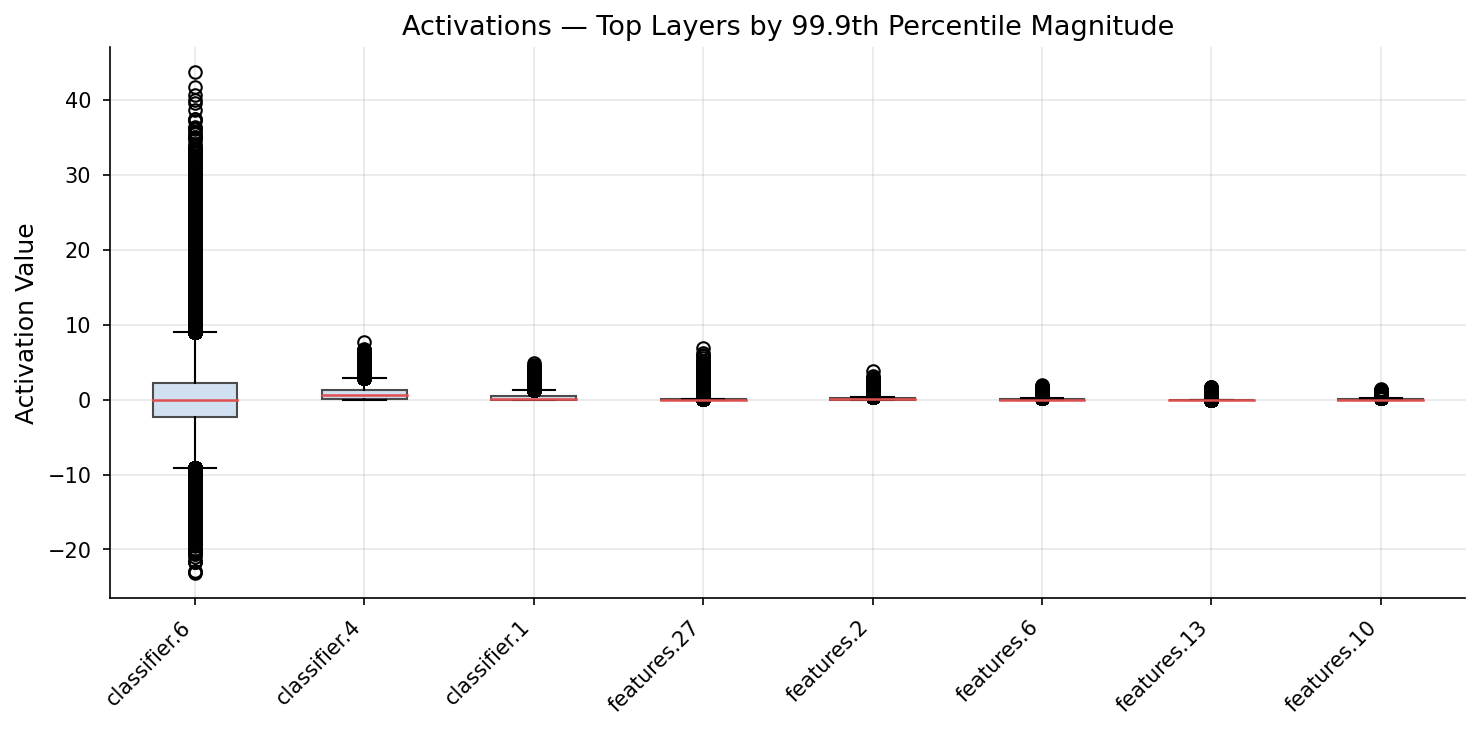

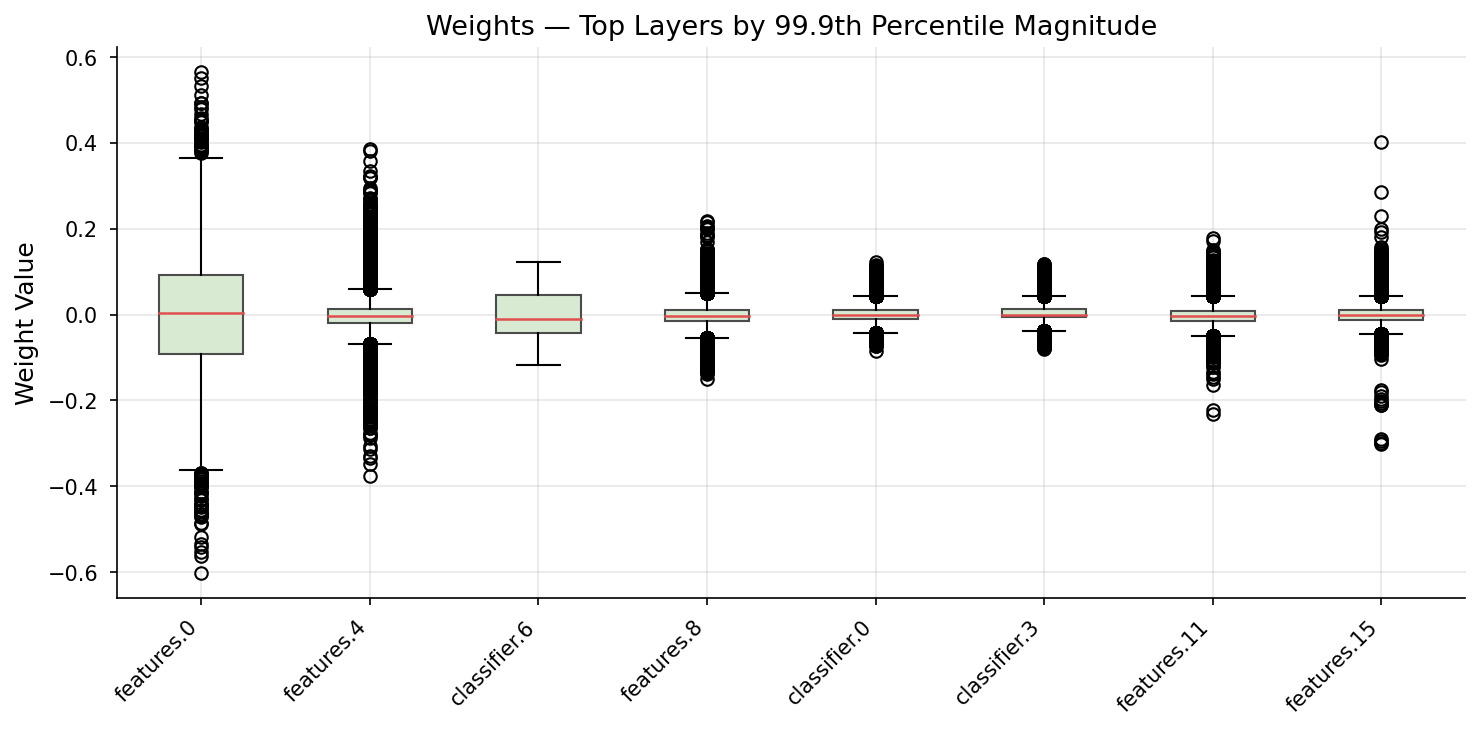

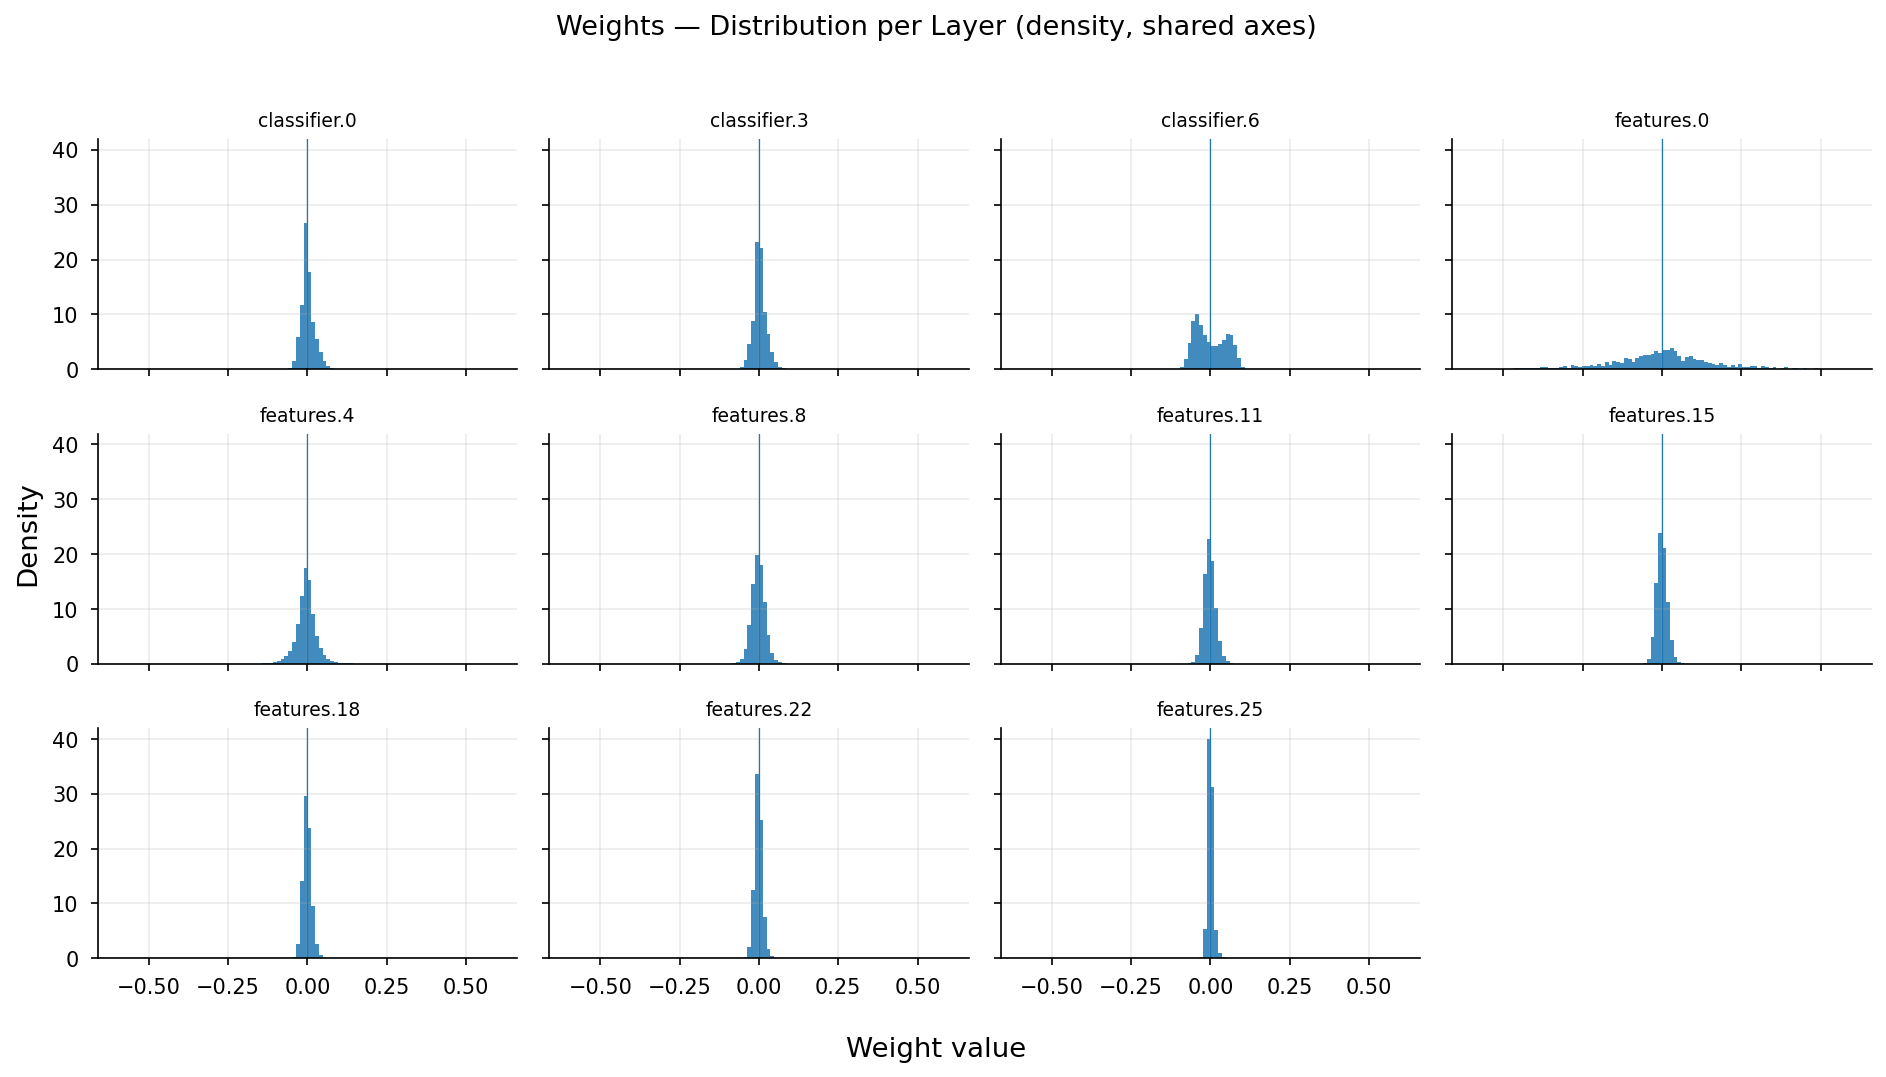

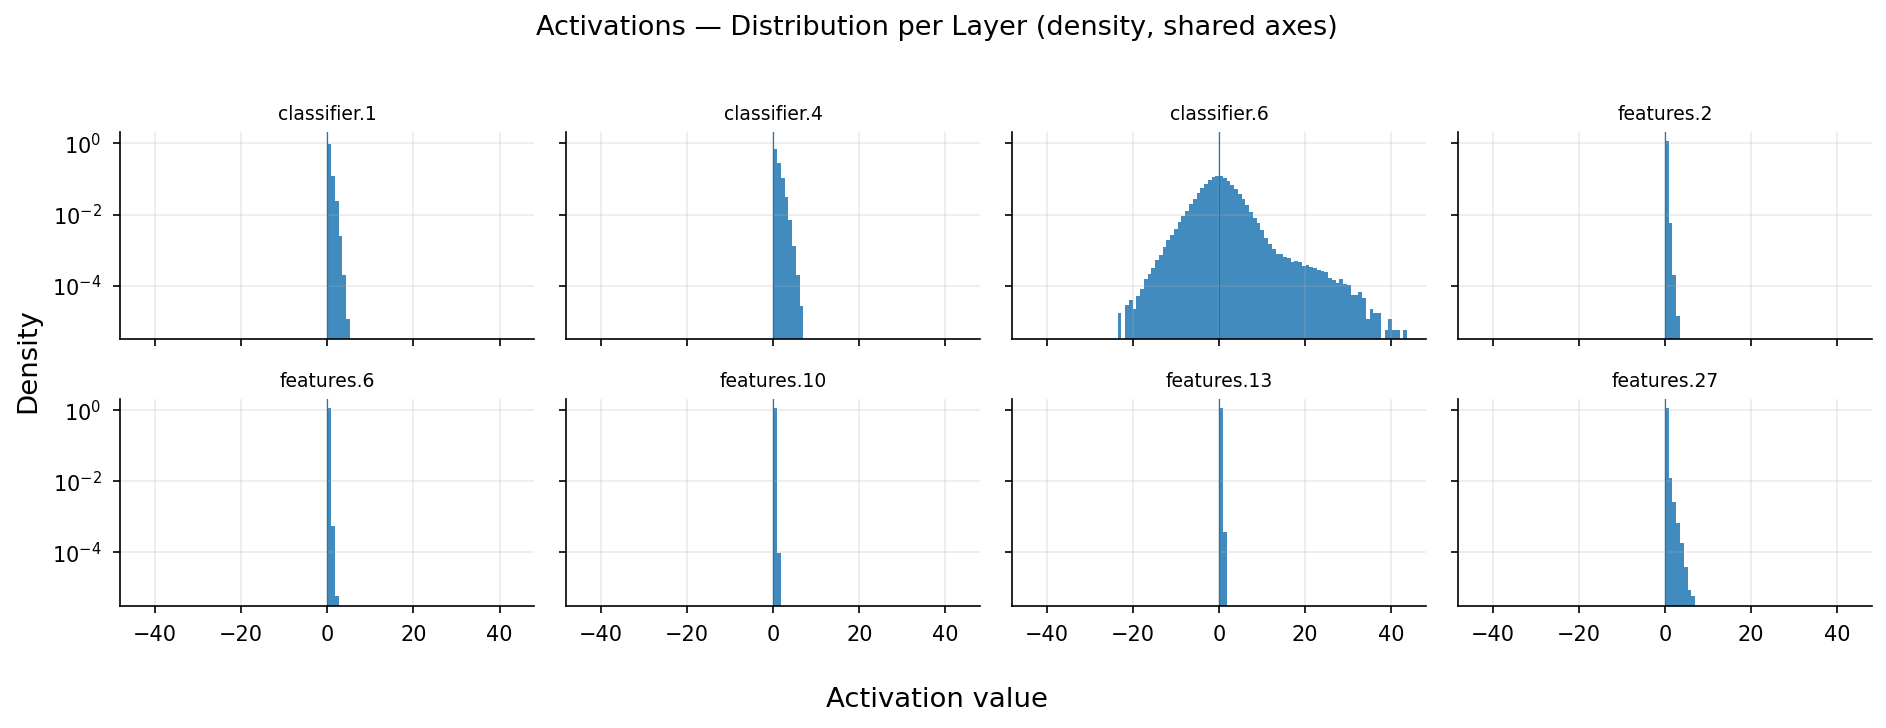

In [1]:
# ============================================================
# Outlier Visualization (Boxplots Only, Paper-Ready)
# VGG-11-BN (CIFAR-100)
# ============================================================

import os, random, math
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# -------------------- Repro / Device --------------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cpu")

# -------------------- Data --------------------
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx = transforms.Compose([transforms.ToTensor(), normalize])

testset = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# -------------------- Model --------------------
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True)
model = model.to(device).eval()

# -------------------- Config --------------------
BATCH_LIMIT           = 8
MAX_SAMPLES_PER_LAYER = 400_000
PER_BATCH_SAMPLES     = 60_000
TOP_K_PLOTS           = 8

# -------------------- Helper --------------------
def reservoir_append(store, key, arr, per_batch_cap, global_cap):
    if arr.size == 0:
        return
    take = min(per_batch_cap, arr.size)
    idx = np.random.choice(arr.size, take, replace=False) if arr.size > take else np.arange(arr.size)
    chunk = arr[idx]
    if key not in store:
        store[key] = chunk
    else:
        remain = max(0, global_cap - store[key].size)
        if remain <= 0:
            return
        if chunk.size > remain:
            chunk = chunk[:remain]
        store[key] = np.concatenate([store[key], chunk], axis=0)

# -------------------- Activation Collection --------------------
act_collect = {}
act_layers = [n for n, m in model.named_modules() if isinstance(m, nn.ReLU)]
last_linear = None
for n, m in model.named_modules():
    if isinstance(m, nn.Linear):
        last_linear = n
if last_linear:
    act_layers.append(last_linear)

def make_hook(name):
    def hook(_, __, out):
        if isinstance(out, torch.Tensor):
            a = out.detach().cpu().view(-1).numpy()
            reservoir_append(act_collect, name, a, PER_BATCH_SAMPLES, MAX_SAMPLES_PER_LAYER)
    return hook

handles = [m.register_forward_hook(make_hook(n)) for n, m in model.named_modules() if n in act_layers]

with torch.no_grad():
    for bidx, (x, _) in enumerate(testloader):
        _ = model(x.to(device))
        if (bidx + 1) >= BATCH_LIMIT:
            break

for h in handles:
    h.remove()

# -------------------- Weight Collection --------------------
weight_collect = {}
for pname, p in model.named_parameters():
    if pname.endswith(".weight"):
        mod_path = pname.rsplit('.', 1)[0]
        try:
            m = model.get_submodule(mod_path)
        except Exception:
            continue
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            w = p.detach().cpu().view(-1).numpy()
            weight_collect[mod_path] = w

# -------------------- Visualization --------------------
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150
})

# ---------- ACTIVATION BOXPLOTS ----------
act_rank = sorted(
    ((name, np.abs(np.percentile(arr, 99.9))) for name, arr in act_collect.items()),
    key=lambda t: t[1], reverse=True
)
act_sel = [n for n, _ in act_rank[:TOP_K_PLOTS]]

plt.figure(figsize=(10, 5))
plt.boxplot([act_collect[n] for n in act_sel],
            labels=act_sel,
            showfliers=True,
            patch_artist=True,
            boxprops=dict(facecolor="#d1e0f0", edgecolor="#4b4b4b"),
            medianprops=dict(color="#e04f4f", linewidth=1.2))
plt.title("Activations — Top Layers by 99.9th Percentile Magnitude")
plt.ylabel("Activation Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- WEIGHT BOXPLOTS ----------
w_rank = sorted(
    ((name, np.abs(np.percentile(arr, 99.9))) for name, arr in weight_collect.items()),
    key=lambda t: t[1], reverse=True
)
w_sel = [n for n, _ in w_rank[:TOP_K_PLOTS]]

plt.figure(figsize=(10, 5))
plt.boxplot([weight_collect[n] for n in w_sel],
            labels=w_sel,
            showfliers=True,
            patch_artist=True,
            boxprops=dict(facecolor="#d9ead3", edgecolor="#4b4b4b"),
            medianprops=dict(color="#e04f4f", linewidth=1.2))
plt.title("Weights — Top Layers by 99.9th Percentile Magnitude")
plt.ylabel("Weight Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------- WEIGHT HISTOGRAMS (ALL Conv/Linear LAYERS) ----------
import re

# Preserve model order; fall back to natural sort by name
def _natkey(s):  # "features.11" < "features.8"
    return [int(t) if t.isdigit() else t for t in re.split(r"(\d+)", s)]

layer_names = list(weight_collect.keys())
layer_names = layer_names or []  # safety
layer_names = sorted(layer_names, key=_natkey)

# Common symmetric binning across layers
global_max = max(np.max(np.abs(weight_collect[n])) for n in layer_names)
bins = np.linspace(-global_max, global_max, 101)

# Grid layout
n = len(layer_names)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 3.2, nrows * 2.4),
    sharex=True, sharey=True
)
axes = np.atleast_1d(axes).ravel()

for ax, name in zip(axes, layer_names):
    w = weight_collect[name]
    ax.hist(w, bins=bins, density=True, edgecolor="none", alpha=0.85)
    ax.set_title(name, fontsize=9)
    ax.axvline(0.0, linewidth=0.6)
    ax.grid(True, alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Hide any empty panels
for ax in axes[len(layer_names):]:
    ax.axis("off")

fig.suptitle("Weights — Distribution per Layer (density, shared axes)", fontsize=13)
fig.supxlabel("Weight value")
fig.supylabel("Density")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


def _natkey(s):
    return [int(t) if t.isdigit() else t for t in re.split(r"(\d+)", s)]

# Rank layers by p99.9(|a|); keep top-K (or all if TOP_K_PLOTS is 0/None)
act_rank = sorted(
    ((name, float(np.percentile(np.abs(arr), 99.9))) for name, arr in act_collect.items()),
    key=lambda t: t[1], reverse=True
)
if TOP_K_PLOTS and TOP_K_PLOTS > 0:
    act_sel = [n for n, _ in act_rank[:TOP_K_PLOTS]]
else:
    act_sel = [n for n, _ in act_rank]

# Optional: natural ordering of the selected names for readability
act_sel = sorted(act_sel, key=_natkey)

# Common symmetric binning across selected layers (handles final Linear with negatives)
amax = max(np.max(np.abs(act_collect[n])) for n in act_sel)
bins = np.linspace(-amax, amax, 101)

# Grid layout
n = len(act_sel)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 3.2, nrows * 2.4),
    sharex=True, sharey=True
)
axes = np.atleast_1d(axes).ravel()

for ax, name in zip(axes, act_sel):
    a = act_collect[name]
    ax.hist(a, bins=bins, density=True, edgecolor="none", alpha=0.85)
    ax.set_title(name, fontsize=9)
    ax.axvline(0.0, linewidth=0.6)
    ax.grid(True, alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Hide extra panels
for ax in axes[len(act_sel):]:
    ax.axis("off")

fig.suptitle("Activations — Distribution per Layer (density, shared axes)", fontsize=13)
fig.supxlabel("Activation value")
fig.supylabel("Density")

# ReLU mass at 0 can dominate; uncomment to see tails better:
for ax in axes[:len(act_sel)]: ax.set_yscale("log")

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [6]:
# ============================================================
# PAPER FIGURES: HISTOGRAMS (VGG-11-BN, CIFAR-100)
# ============================================================
import os, math, numpy as np, matplotlib.pyplot as plt

SAVE_DIR = "/kaggle/working/paper_viz_final"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------------------- Manual Layer Selection --------------------
w_sel = ["features.0", "features.11", "classifier.0"]
a_sel = ["features.2", "features.13", "classifier.6"]

print("Selected weight layers:", w_sel)
print("Selected activation layers:", a_sel)

# -------------------- Style --------------------
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150
})

# ============================================================
# INDIVIDUAL HISTOGRAMS
# ============================================================
for name in w_sel:
    w = weight_collect[name]
    bins = np.linspace(-np.max(np.abs(w)), np.max(np.abs(w)), 101)
    plt.figure(figsize=(4,4))
    plt.hist(w, bins=bins, density=True, edgecolor="none", alpha=0.85)
    plt.axvline(0.0, linewidth=0.6)
    plt.grid(True, alpha=0.25)
    plt.title(f"Weights — {name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"hist_weights_{name.replace('.', '_')}.png"))
    plt.close()

for name in a_sel:
    a = act_collect[name]
    bins = np.linspace(-np.max(np.abs(a)), np.max(np.abs(a)), 101)
    plt.figure(figsize=(4,4))
    plt.hist(a, bins=bins, density=True, edgecolor="none", alpha=0.85)
    plt.axvline(0.0, linewidth=0.6)
    plt.grid(True, alpha=0.25)
    plt.title(f"Activations — {name}")
    plt.xlabel("Activation Value")
    plt.ylabel("Density")
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"hist_activations_{name.replace('.', '_')}.png"))
    plt.close()

# ============================================================
# COMBINED GRID FIGURES (1×3, shared y-axis, log-scale)
# ============================================================
# ---------- Weights ----------
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True)
for ax, name in zip(axes, w_sel):
    w = weight_collect[name]
    bins = np.linspace(-np.max(np.abs(w)), np.max(np.abs(w)), 101)
    ax.hist(w, bins=bins, density=True, edgecolor="none", alpha=0.85)
    ax.axvline(0.0, linewidth=0.6)
    ax.set_title(name, fontsize=9)
    ax.set_yscale("log")
    ax.grid(True, alpha=0.25)
fig.suptitle("Representative Weight Distributions (Early / Mid / Late)")
fig.supxlabel("Weight Value")
fig.supylabel("Density")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig(os.path.join(SAVE_DIR, "hist_weights_grid.png"))
plt.close()

# ---------- Activations ----------
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True)
for ax, name in zip(axes, a_sel):
    a = act_collect[name]
    bins = np.linspace(-np.max(np.abs(a)), np.max(np.abs(a)), 101)
    ax.hist(a, bins=bins, density=True, edgecolor="none", alpha=0.85)
    ax.axvline(0.0, linewidth=0.6)
    ax.set_title(name, fontsize=9)
    ax.set_yscale("log")
    ax.grid(True, alpha=0.25)
fig.suptitle("Representative Activation Distributions (Early / Mid / Late)")
fig.supxlabel("Activation Value")
fig.supylabel("Density")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig(os.path.join(SAVE_DIR, "hist_activations_grid.png"))
plt.close()

print(f"All representative histogram plots saved to: {SAVE_DIR}")


Selected weight layers: ['features.0', 'features.11', 'classifier.0']
Selected activation layers: ['features.2', 'features.13', 'classifier.6']
All representative histogram plots saved to: /kaggle/working/paper_viz_final


In [7]:
import shutil

# Path to your folder
folder_path = "/kaggle/working/paper_viz_final"
zip_path = "/kaggle/working/paper_viz_final.zip"

# Create zip archive
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)
print("Zipped to:", zip_path)


Zipped to: /kaggle/working/paper_viz_final.zip


In [8]:
# ============================================================
# PAPER FIGURE: 2x3 HISTOGRAM GRID (VGG-11-BN, CIFAR-100)
# Requires: weight_collect, act_collect already populated
# ============================================================
import os, numpy as np, matplotlib.pyplot as plt

SAVE_DIR = "/kaggle/working/paper_viz_final"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---- Select layers (Early / Mid / Late) ----
w_sel = ["features.0", "features.11", "classifier.0"]
a_sel = ["features.2", "features.13", "classifier.6"]

# ---- Sanity checks to avoid KeyError ----
missing_w = [n for n in w_sel if n not in weight_collect]
missing_a = [n for n in a_sel if n not in act_collect]
if missing_w or missing_a:
    print("[WARN] Missing:", {"weights": missing_w, "activations": missing_a})
    # Drop missing ones but keep order; fill with existing if needed
    w_sel = [n for n in w_sel if n in weight_collect]
    a_sel = [n for n in a_sel if n in act_collect]

# ---- Style ----
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150,
})

# ---- Shared symmetric bins per row ----
def symmetric_bins(arr_list, nbins=101, eps=1e-12):
    xmax = max(float(np.max(np.abs(a))) for a in arr_list)
    xmax = xmax if np.isfinite(xmax) and xmax > eps else 1.0
    return np.linspace(-xmax, xmax, nbins)

w_arrays = [weight_collect[n] for n in w_sel]
a_arrays = [act_collect[n]  for n in a_sel]

bins_w = symmetric_bins(w_arrays, nbins=101)
bins_a = symmetric_bins(a_arrays, nbins=101)

# ---- Figure: 2 x 3 grid ----
fig, axes = plt.subplots(2, 3, figsize=(10.8, 4.6), sharey='row')

# Top row: weights
for ax, name in zip(axes[0], w_sel):
    w = weight_collect[name]
    ax.hist(w, bins=bins_w, density=True, edgecolor="none", alpha=0.85)
    ax.axvline(0.0, linewidth=0.6)
    ax.set_title(name, fontsize=10)
    ax.set_yscale("log")
    ax.grid(True, alpha=0.25)

axes[0,0].set_ylabel("Density")
for ax in axes[0]:
    ax.set_xlabel("")

# Bottom row: activations
for ax, name in zip(axes[1], a_sel):
    a = act_collect[name]
    ax.hist(a, bins=bins_a, density=True, edgecolor="none", alpha=0.85)
    ax.axvline(0.0, linewidth=0.6)
    ax.set_title(name, fontsize=10)
    ax.set_yscale("log")
    ax.grid(True, alpha=0.25)

axes[1,0].set_ylabel("Density")
for ax in axes[1]:
    ax.set_xlabel("Value")

fig.suptitle("Representative Distributions — Weights (top) / Activations (bottom)")
fig.tight_layout(rect=[0, 0, 1, 0.94])

out_png = os.path.join(SAVE_DIR, "hist_2x3_weights_activations.png")
out_pdf = os.path.join(SAVE_DIR, "hist_2x3_weights_activations.pdf")
plt.savefig(out_png, dpi=300)
plt.savefig(out_pdf)   # vector for Overleaf
plt.close()
print("Saved:", out_png, "and", out_pdf)


Saved: /kaggle/working/paper_viz_final/hist_2x3_weights_activations.png and /kaggle/working/paper_viz_final/hist_2x3_weights_activations.pdf


In [4]:
# ============================================================
# PTQ INT8 (FBGEMM) — Min-Max vs Percentile Grid (MSE proxy)
# Model: VGG-11-BN (CIFAR-100)
# Proxy: Average MSE( logits_fp32 , logits_int8 ) over calibration set
# ============================================================

import math, collections, copy, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# -------------------- Repro / Backend --------------------
SEED = 1337
torch.manual_seed(SEED); np.random.seed(SEED)
torch.backends.quantized.engine = "fbgemm"  # CPU INT8 backend
device = torch.device("cpu")

# -------------------- Data --------------------
print("Setting up data loaders...")
normalize = transforms.Normalize((0.5071, 0.4867, 0.4408),
                                 (0.2675, 0.2565, 0.2761))
tx_train = transforms.Compose([transforms.ToTensor(), normalize])
tx_test  = transforms.Compose([transforms.ToTensor(), normalize])

trainset = torchvision.datasets.CIFAR100(root="./data", train=True,  download=True, transform=tx_train)
testset  = torchvision.datasets.CIFAR100(root="./data", train=False, download=True, transform=tx_test)

def make_balanced_subset(dataset, num_classes=100, per_class=10):
    targets = dataset.targets if hasattr(dataset, "targets") else dataset.labels
    buckets = [[] for _ in range(num_classes)]
    for idx, y in enumerate(targets):
        if len(buckets[y]) < per_class:
            buckets[y].append(idx)
        if all(len(b) >= per_class for b in buckets):
            break
    idxs = [i for b in buckets for i in b]
    return torch.utils.data.Subset(dataset, idxs)

PER_CLASS = 10
calib_subset = make_balanced_subset(trainset, per_class=PER_CLASS)
print(f"Calibration subset: {len(calib_subset)} images ({PER_CLASS} per class)")

calibloader = torch.utils.data.DataLoader(calib_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,      batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# -------------------- FP32 Model --------------------
print("Loading FP32 model...")
def fresh_model():
    # Torch Hub uses local cache after first download
    return torch.hub.load("chenyaofo/pytorch-cifar-models",
                          "cifar100_vgg11_bn", pretrained=True).to(device).eval()

model_fp32 = fresh_model()

# -------------------- Custom Percentile Observers --------------------
import torch.ao.quantization as tq
from torch.ao.quantization.observer import ObserverBase, MinMaxObserver, PerChannelMinMaxObserver

class PercentileMinMaxObserver(ObserverBase):
    """
    ACTIVATIONS: per-tensor affine (UINT8) using [lower_q, upper_q] percentiles of x.
    """
    def __init__(self, dtype=torch.quint8, qscheme=torch.per_tensor_affine,
                 quant_min=0, quant_max=255, lower_q=0.0001, upper_q=0.9999, eps=1e-7):
        super().__init__(dtype=dtype)
        self.dtype = dtype
        self.qscheme = qscheme
        self.quant_min = int(quant_min)
        self.quant_max = int(quant_max)
        self.lower_q = float(lower_q)
        self.upper_q = float(upper_q)
        self.eps = float(eps)
        self.register_buffer("min_val", torch.tensor(float("inf")))
        self.register_buffer("max_val", torch.tensor(float("-inf")))
        self.is_dynamic = False

    def forward(self, x_orig):
        if x_orig.numel() == 0:
            return x_orig
        x = x_orig.detach().to(torch.float32)
        lo = torch.quantile(x, self.lower_q)
        hi = torch.quantile(x, self.upper_q)
        self.min_val = torch.minimum(self.min_val, lo)
        self.max_val = torch.maximum(self.max_val, hi)
        return x_orig

    def calculate_qparams(self):
        min_val = torch.minimum(self.min_val, self.max_val)
        max_val = torch.maximum(self.min_val, self.max_val)
        rng = max_val - min_val
        if torch.isnan(rng) or (rng < self.eps):
            scale = torch.tensor([1.0], dtype=torch.float32)
            zero_point = torch.tensor([0], dtype=torch.int64)
            return scale, zero_point
        scale = (rng / float(self.quant_max - self.quant_min)).to(torch.float32)
        zp = self.quant_min - torch.round(min_val / scale)
        zp = torch.clamp(zp, self.quant_min, self.quant_max).to(torch.int64)
        return scale.view(1), zp.view(1)

class PercentilePerChannelMinMaxObserver(ObserverBase):
    """
    WEIGHTS: per-channel symmetric (INT8) using upper percentile of |w|.
    """
    def __init__(self, dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
                 ch_axis=0, quant_min=-128, quant_max=127, upper_q=0.9999, eps=1e-7):
        super().__init__(dtype=dtype)
        self.dtype = dtype
        self.qscheme = qscheme
        self.ch_axis = int(ch_axis)
        self.quant_min = int(quant_min)
        self.quant_max = int(quant_max)
        self.upper_q = float(upper_q)
        self.eps = float(eps)
        self.register_buffer("min_val", torch.tensor([]))
        self.register_buffer("max_val", torch.tensor([]))
        self.is_dynamic = False

    def forward(self, x_orig):
        if x_orig.numel() == 0:
            return x_orig
        x = x_orig.detach().to(torch.float32)
        x_chfirst = x.transpose(self.ch_axis, 0).contiguous()
        C = x_chfirst.shape[0]
        if self.min_val.numel() == 0:
            self.min_val = torch.full((C,), float("inf"), device=x.device)
            self.max_val = torch.full((C,), float("-inf"), device=x.device)
        for c in range(C):
            ch = x_chfirst[c].reshape(-1)
            thr = torch.quantile(ch.abs(), self.upper_q)
            lo, hi = -thr, thr
            self.min_val[c] = torch.minimum(self.min_val[c], lo)
            self.max_val[c] = torch.maximum(self.max_val[c], hi)
        return x_orig

    def calculate_qparams(self):
        max_abs = torch.maximum(self.max_val.abs(), self.min_val.abs())
        max_abs = torch.clamp(max_abs, min=self.eps)
        qmax = float(self.quant_max)  # 127
        scale = (max_abs / qmax).to(torch.float32)
        zero_point = torch.zeros_like(scale, dtype=torch.int64)
        return scale, zero_point

# Factories for FX
ActMinMax      = MinMaxObserver.with_args(dtype=torch.quint8, qscheme=torch.per_tensor_affine,
                                          quant_min=0, quant_max=255)
WgtPerChMinMax = PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
                                                    ch_axis=0, quant_min=-128, quant_max=127)

def ActPctFactory(p_upper: float):
    # p_upper is in [0,1], mirror lower tail
    return PercentileMinMaxObserver.with_args(dtype=torch.quint8, qscheme=torch.per_tensor_affine,
                                              quant_min=0, quant_max=255,
                                              lower_q=max(0.0, 1.0 - p_upper), upper_q=p_upper)

def WgtPctFactory(p_upper: float):
    return PercentilePerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric,
                                                        ch_axis=0, quant_min=-128, quant_max=127,
                                                        upper_q=p_upper)

# -------------------- FX Utils --------------------
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping

def prepare_convert_with_qconfig(model_fp32: nn.Module, qconfig: tq.QConfig, example_inputs):
    qmap = QConfigMapping().set_global(qconfig)
    prepared = prepare_fx(model_fp32, qmap, example_inputs=example_inputs)
    with torch.inference_mode():
        for x, _ in calibloader:
            prepared(x.to(device, dtype=torch.float32))
    qmodel = convert_fx(prepared).eval()
    return qmodel

@torch.no_grad()
def logits_mse(fp32_model: nn.Module, q_model: nn.Module, loader) -> float:
    """Average MSE between FP32 logits and quantized logits over 'loader'."""
    se_sum, n_sum = 0.0, 0
    for x, _ in loader:
        x = x.to(device, dtype=torch.float32)
        logits_fp = fp32_model(x)
        logits_q  = q_model(x)
        # ensure both are float
        logits_fp = logits_fp.to(torch.float32)
        logits_q  = logits_q.to(torch.float32)
        diff = (logits_fp - logits_q).flatten(1)
        se_sum += (diff * diff).sum().item()
        n_sum  += diff.numel()
    return se_sum / max(1, n_sum)

@torch.no_grad()
def top1(model: nn.Module, loader) -> float:
    correct = total = 0
    for x, y in loader:
        x = x.to(device, dtype=torch.float32); y = y.to(device)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

def summarize_quantization(gm: torch.fx.GraphModule, title: str):
    gm.graph.lint(); gm.recompile()
    mod_counts = collections.Counter()
    q_input_calls = dq_output_calls = 0
    for _, m in gm.named_modules():
        modpath = m.__class__.__module__
        if modpath.startswith("torch.ao.nn.quantized"):
            mod_counts[m.__class__.__name__] += 1
    for n in gm.graph.nodes:
        if n.op == "call_function" and n.target is torch.quantize_per_tensor:
            q_input_calls += 1
        if n.op == "call_method" and n.target == "dequantize":
            dq_output_calls += 1
    print(f"\n=== Quantization verification: {title} ===")
    if mod_counts:
        print("Quantized modules:")
        for k, v in mod_counts.most_common():
            print(f"  {k}: {v}")
    else:
        print("No quantized modules detected.")
    print(f"quantize_per_tensor nodes: {q_input_calls}")
    print(f"dequantize() nodes       : {dq_output_calls}")
    print("STATUS:", "QUANTIZED" if (mod_counts or (q_input_calls>0 and dq_output_calls>0)) else "NOT QUANTIZED")

# -------------------- Baseline: Min-Max --------------------
example_inputs = (torch.randn(1, 3, 32, 32),)
print("\nPreparing Min-Max baseline...")
qconfig_minmax = tq.QConfig(activation=ActMinMax, weight=WgtPerChMinMax)
int8_minmax = prepare_convert_with_qconfig(fresh_model(), qconfig_minmax, example_inputs)
summarize_quantization(int8_minmax, "INT8 Min-Max")

print("\nEvaluating baselines...")
acc_fp32   = top1(model_fp32, testloader)
acc_minmax = top1(int8_minmax, testloader)
print(f"FP32  accuracy : {acc_fp32:.2f}%")
print(f"INT8 Min-Max accuracy : {acc_minmax:.2f}%")

# -------------------- Percentile Grid Search (MSE proxy) --------------------
# Grids (log-dense near tails)
ACT_PCTS = [99.0, 99.5, 99.7, 99.8, 99.9, 99.95]  # activations (per-tensor)
WGT_PCTS = [99.0, 99.5, 99.9]                     # weights (per-channel)

print("\nSweeping percentile grid with MSE proxy...")
best = {"mse": float("inf"), "pa": None, "pw": None, "model": None}

for pa in ACT_PCTS:
    for pw in WGT_PCTS:
        p_act = pa / 100.0
        p_wgt = pw / 100.0
        qconfig_pct = tq.QConfig(
            activation=ActPctFactory(p_act),
            weight=    WgtPctFactory(p_wgt)
        )
        qmodel = prepare_convert_with_qconfig(fresh_model(), qconfig_pct, example_inputs)
        mse = logits_mse(model_fp32, qmodel, calibloader)
        print(f"  [ACT={pa:.3f}%, WGT={pw:.3f}%]  MSE={mse:.6e}")
        if mse < best["mse"]:
            best = {"mse": mse, "pa": pa, "pw": pw, "model": qmodel}

best_model = best["model"]
print("\n=== Best percentile combo (MSE proxy) ===")
print(f"Activations p*: {best['pa']}%   |   Weights p*: {best['pw']}%")
print(f"MSE (logits vs FP32): {best['mse']:.6e}")
summarize_quantization(best_model, "INT8 Percentile (best by MSE)")

# -------------------- Final Evaluation --------------------
acc_best = top1(best_model, testloader)
print("\n=== TEST ACCURACY ===")
print(f"FP32               : {acc_fp32:.2f}%")
print(f"INT8 Min-Max       : {acc_minmax:.2f}%")
print(f"INT8 Percentile(*) : {acc_best:.2f}%  (ACT={best['pa']}%, WGT={best['pw']}%)")


Setting up data loaders...
Calibration subset: 1000 images (10 per class)
Loading FP32 model...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



Preparing Min-Max baseline...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



=== Quantization verification: INT8 Min-Max ===
Quantized modules:
  LinearPackedParams: 3
  Dropout: 2
  Linear: 1
quantize_per_tensor nodes: 1
dequantize() nodes       : 1
STATUS: QUANTIZED

Evaluating baselines...
FP32  accuracy : 70.80%
INT8 Min-Max accuracy : 46.44%

Sweeping percentile grid with MSE proxy...


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.000%, WGT=99.000%]  MSE=1.255939e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.000%, WGT=99.500%]  MSE=1.123644e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.000%, WGT=99.900%]  MSE=1.014248e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.500%, WGT=99.000%]  MSE=1.146006e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.500%, WGT=99.500%]  MSE=1.014396e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.500%, WGT=99.900%]  MSE=9.125138e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.700%, WGT=99.000%]  MSE=1.103788e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.700%, WGT=99.500%]  MSE=9.735115e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.700%, WGT=99.900%]  MSE=8.740820e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.800%, WGT=99.000%]  MSE=1.081005e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.800%, WGT=99.500%]  MSE=9.511560e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.800%, WGT=99.900%]  MSE=8.528140e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.900%, WGT=99.000%]  MSE=1.061356e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.900%, WGT=99.500%]  MSE=9.303520e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.900%, WGT=99.900%]  MSE=8.318433e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.950%, WGT=99.000%]  MSE=1.053738e+01


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.950%, WGT=99.500%]  MSE=9.220145e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  [ACT=99.950%, WGT=99.900%]  MSE=8.234676e+00

=== Best percentile combo (MSE proxy) ===
Activations p*: 99.95%   |   Weights p*: 99.9%
MSE (logits vs FP32): 8.234676e+00

=== Quantization verification: INT8 Percentile (best by MSE) ===
Quantized modules:
  LinearPackedParams: 3
  Dropout: 2
  Linear: 1
quantize_per_tensor nodes: 1
dequantize() nodes       : 1
STATUS: QUANTIZED

=== TEST ACCURACY ===
FP32               : 70.80%
INT8 Min-Max       : 46.44%
INT8 Percentile(*) : 46.31%  (ACT=99.95%, WGT=99.9%)


In [5]:
print(best_model)

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.007304314058274031, zero_point=0, padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.004292055033147335, zero_point=0, padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.0027099614962935448, zero_point=0, padding=(1, 1))
    (11): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.003972793463617563, zero_point=0, padding=(1, 1))
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): QuantizedConvReLU2d(256, 512, kernel_size=(3, 3), stride=(1, 1), scale=0.0026850057765841484, zero_point=0, padding=(1, 1))
    (18): QuantizedConvReLU2d(512, 512, kernel_size=

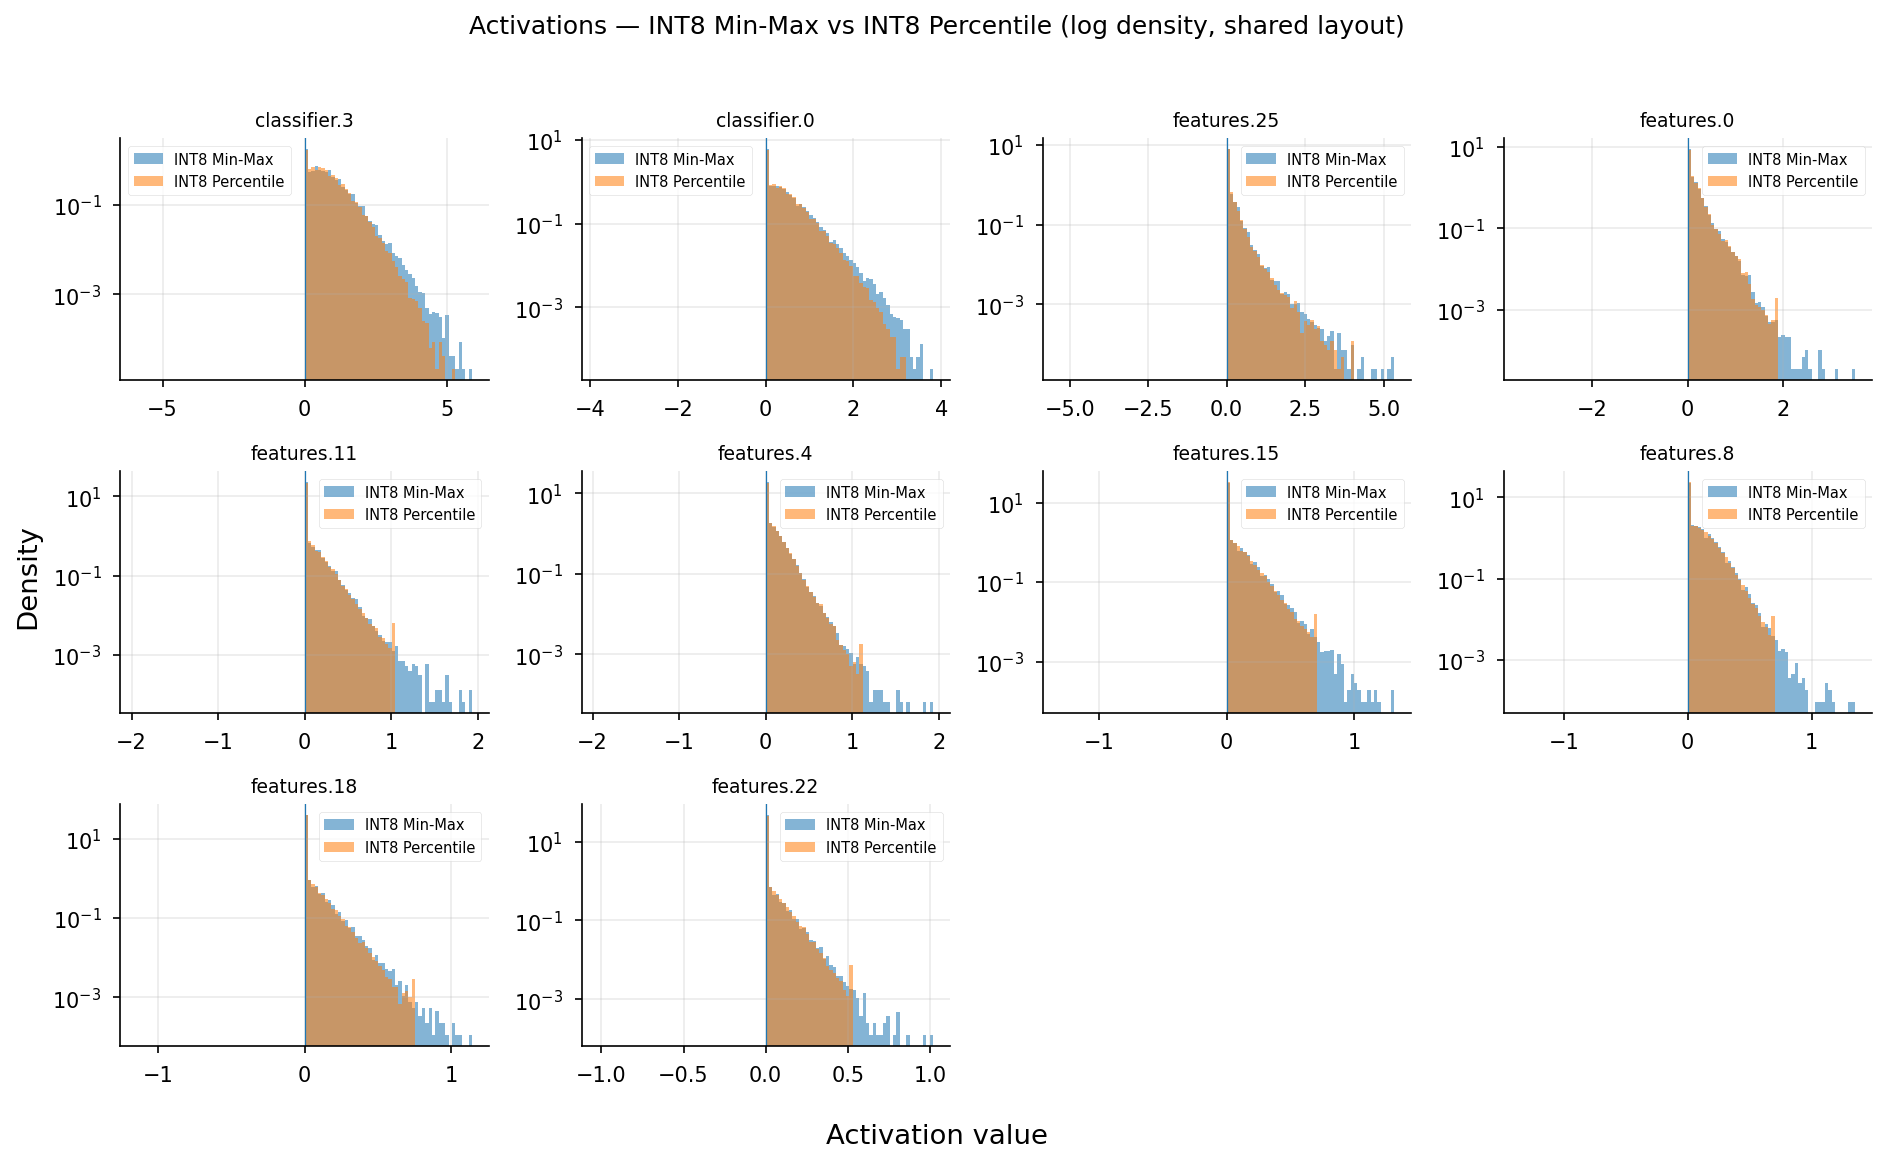

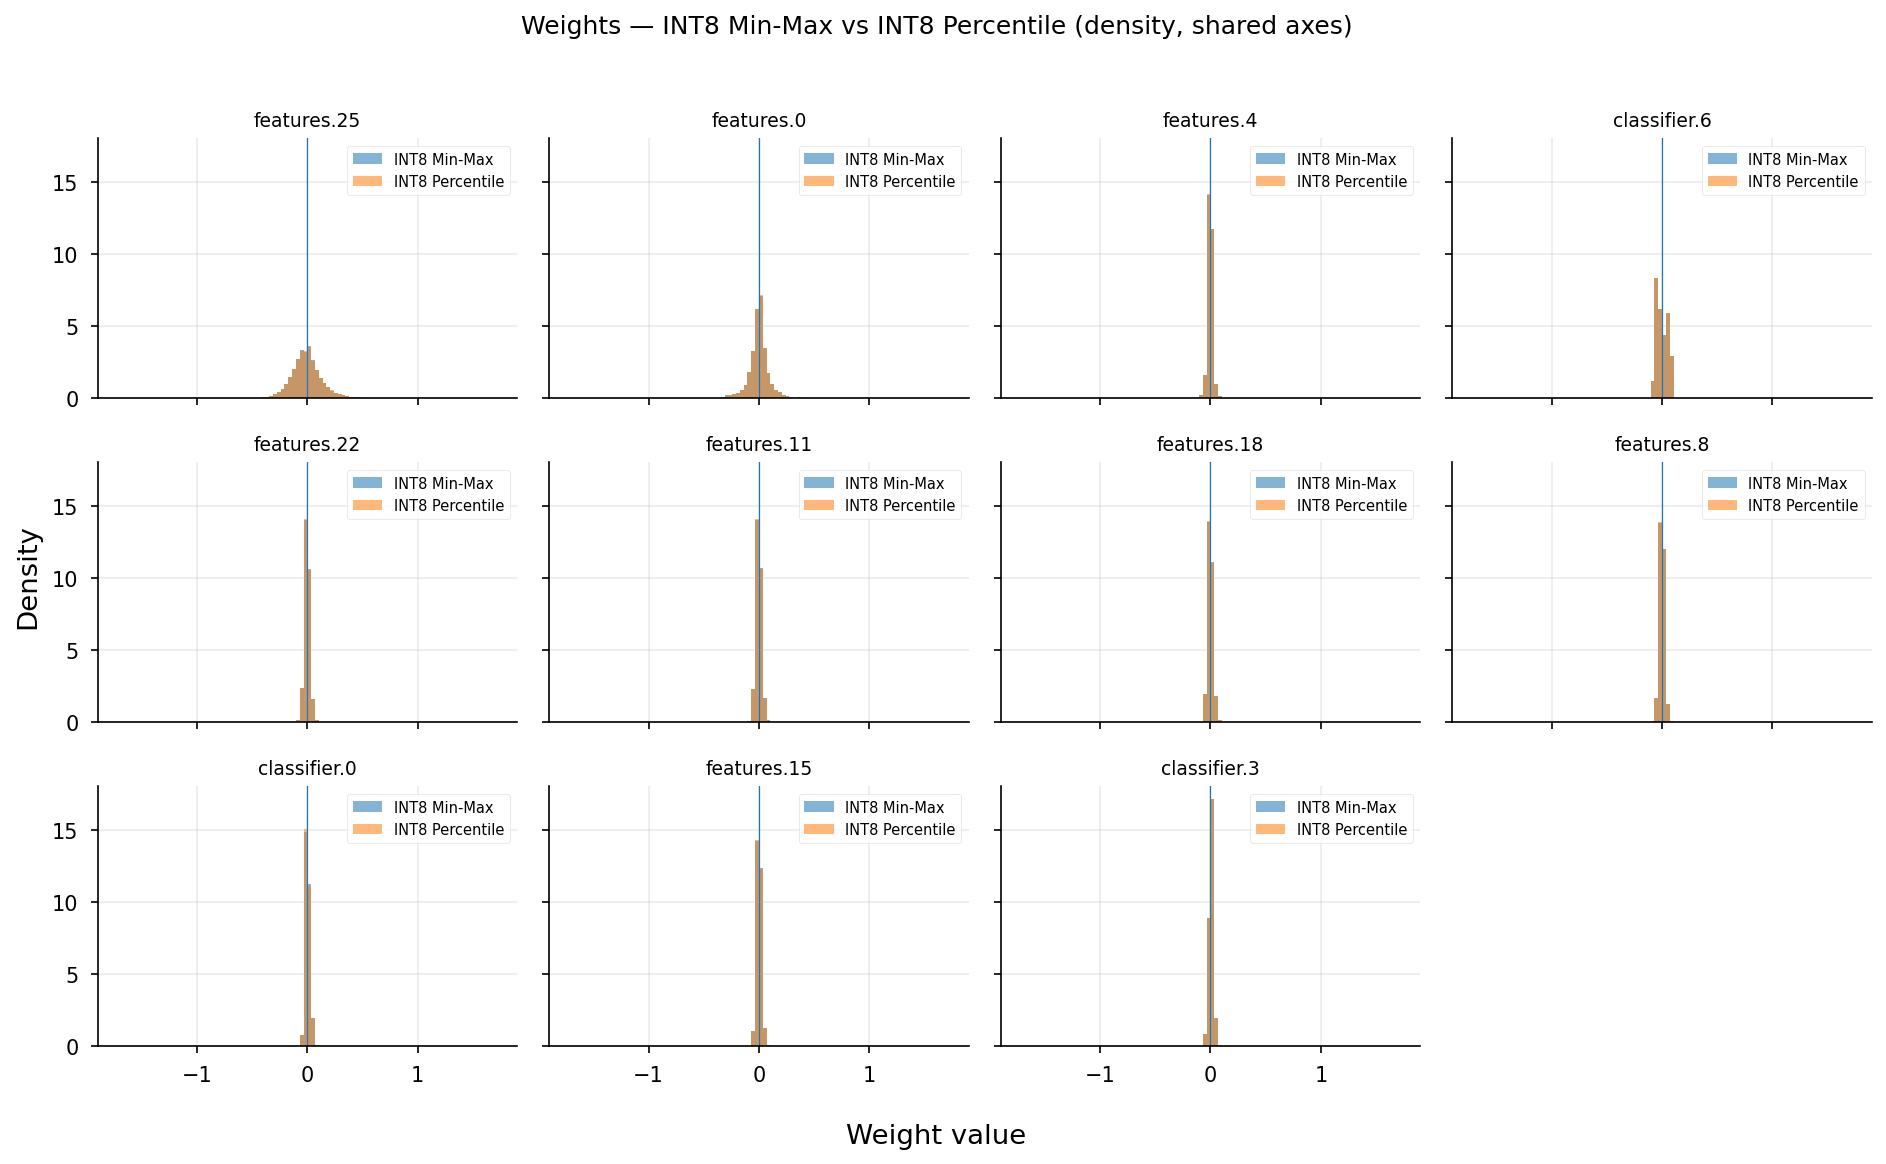

In [7]:
# ============================================================
# Subplot Grids — INT8 Min-Max vs INT8 Percentile ("best_model")
# - Activations: post-ReLU (or fused ConvReLU) + final Linear
# - Weights    : Conv/Linear (dequantized for plotting)
# ============================================================

import math, re, random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cpu")

# -------------------- Config --------------------
BATCH_LIMIT           = 8            # test batches to scan for activations
PER_BATCH_SAMPLES     = 60_000       # per-layer per-batch cap
MAX_SAMPLES_PER_LAYER = 400_000      # per-layer global cap
TOP_K_ACTS            = 12           # number of activation panels (grid)
TOP_K_WGTS            = 12           # number of weight panels (grid)
NCOLS                  = 4           # columns in subplot grids

# -------------------- Utils --------------------
def _is_q(t): return hasattr(t, "is_quantized") and bool(getattr(t, "is_quantized"))

def _reservoir_append(store, key, arr, per_batch_cap, global_cap):
    if arr.size == 0: return
    take = min(per_batch_cap, arr.size)
    if arr.size > take:
        idx = np.random.choice(arr.size, take, replace=False); chunk = arr[idx]
    else:
        chunk = arr
    if key not in store:
        store[key] = chunk
    else:
        remain = max(0, global_cap - store[key].size)
        if remain <= 0: return
        if chunk.size > remain: chunk = chunk[:remain]
        store[key] = np.concatenate([store[key], chunk], axis=0)

def _probe_names(model: nn.Module):
    """Tap post-activation points: any module whose class name includes 'relu'; also final Linear."""
    names, last_linear = [], None
    for n, m in model.named_modules():
        cname = m.__class__.__name__.lower()
        if "relu" in cname:
            names.append(n)
        if isinstance(m, nn.Linear) or ("linear" in cname):
            last_linear = n
    seen, ordered = set(), []
    for n in names:
        if n not in seen: ordered.append(n); seen.add(n)
    if last_linear and last_linear not in seen: ordered.append(last_linear)
    return ordered

def collect_acts(model: nn.Module, loader, layer_names, batch_limit=BATCH_LIMIT):
    """Collect flattened post-activation values from listed modules; dequantize if needed."""
    store, handles = {}, []
    def make_hook(name):
        def hook(_, __, out):
            if not torch.is_tensor(out): return
            t = out.dequantize() if _is_q(out) else out
            a = t.detach().to("cpu").reshape(-1).numpy()
            _reservoir_append(store, name, a, PER_BATCH_SAMPLES, MAX_SAMPLES_PER_LAYER)
        return hook
    for name in layer_names:
        try:
            mod = model.get_submodule(name)
            handles.append(mod.register_forward_hook(make_hook(name)))
        except Exception:
            pass
    model.eval()
    with torch.no_grad():
        for bidx, (x, _) in enumerate(loader):
            _ = model(x.to(device, dtype=torch.float32))
            if (bidx + 1) >= batch_limit: break
    for h in handles: h.remove()
    return store

def collect_wgts(model: nn.Module):
    """Collect dequantized Conv/Linear weights; returns dict(name -> 1D numpy array)."""
    out = {}
    for name, m in model.named_modules():
        is_dense = isinstance(m, (nn.Conv2d, nn.Linear)) or \
                   any(k in m.__class__.__name__.lower() for k in ["conv", "linear"])
        if not is_dense: continue
        w = None
        if hasattr(m, "weight") and callable(getattr(m, "weight")):
            try: w = m.weight()
            except Exception: w = None
        if w is None and hasattr(m, "weight"):
            try: w = m.weight
            except Exception: w = None
        if w is None or not torch.is_tensor(w): continue
        wt = w.dequantize() if _is_q(w) else w
        vec = wt.detach().to("cpu").reshape(-1).numpy()
        if vec.size: out[name] = vec
    return out

def _natkey(s):  # "features.11" < "features.8"
    return [int(t) if t.isdigit() else t for t in re.split(r"(\d+)", s or "")]

# -------------------- Targets --------------------
minmax = int8_minmax.eval()
best   = best_model.eval()

# -------------------- ACTIVATIONS (Min-Max vs Best) --------------------
# Align probe points by index to be robust to fusion differences
pts_minmax = _probe_names(minmax)
pts_best   = _probe_names(best)
L = min(len(pts_minmax), len(pts_best))
pts_minmax, pts_best = pts_minmax[:L], pts_best[:L]

act_min = collect_acts(minmax, testloader, pts_minmax)
act_bst = collect_acts(best,   testloader, pts_best)

# Rank by joint extremity (max p99.9 |a| across the two models) and select top-K
rank = []
for i in range(L):
    a1 = act_min.get(pts_minmax[i], np.array([]))
    a2 = act_bst.get(pts_best[i],   np.array([]))
    if a1.size == 0 and a2.size == 0: continue
    score = 0.0
    if a1.size: score = max(score, float(np.percentile(np.abs(a1), 99.9)))
    if a2.size: score = max(score, float(np.percentile(np.abs(a2), 99.9)))
    rank.append((i, score))
rank.sort(key=lambda t: t[1], reverse=True)
sel_idx = [i for i, _ in rank[:min(TOP_K_ACTS, len(rank))]]

# Subplot grid for ACTIVATIONS (overlaid histograms; shared axes; log y)
n = len(sel_idx)
ncols = NCOLS
nrows = max(1, math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.2, nrows*2.6), sharex=False, sharey=False)
axes = np.atleast_1d(axes).ravel()

for ax, i in zip(axes, sel_idx):
    nm1, nm2 = pts_minmax[i], pts_best[i]
    a1 = act_min.get(nm1, np.array([]))
    a2 = act_bst.get(nm2, np.array([]))
    if a1.size == 0 or a2.size == 0:
        ax.axis("off"); continue
    amax = max(np.max(np.abs(a1)), np.max(np.abs(a2)))
    bins = np.linspace(-amax, amax, 101)
    ax.hist(a1, bins=bins, density=True, alpha=0.55, label="INT8 Min-Max")
    ax.hist(a2, bins=bins, density=True, alpha=0.55, label="INT8 Percentile")
    ax.set_title(nm1, fontsize=9)
    ax.set_yscale("log")                 # expose mass near zero and tails
    ax.grid(True, alpha=0.25)
    ax.axvline(0.0, linewidth=0.6)
    ax.legend(fontsize=7)
for ax in axes[n:]:
    ax.axis("off")
fig.suptitle("Activations — INT8 Min-Max vs INT8 Percentile (log density, shared layout)", fontsize=12)
fig.supxlabel("Activation value"); fig.supylabel("Density")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# -------------------- WEIGHTS (Min-Max vs Best) --------------------
w_min = collect_wgts(minmax)
w_bst = collect_wgts(best)

common = sorted(set(w_min.keys()).intersection(w_bst.keys()), key=_natkey)
# Rank by joint extremity (p99.9 |w|) and select top-K
wrank = []
for nme in common:
    s = max(float(np.percentile(np.abs(w_min[nme]), 99.9)),
            float(np.percentile(np.abs(w_bst[nme]), 99.9)))
    wrank.append((nme, s))
wrank.sort(key=lambda t: t[1], reverse=True)
w_sel = [nme for nme, _ in wrank[:min(TOP_K_WGTS, len(wrank))]]

n = len(w_sel)
ncols = NCOLS
nrows = max(1, math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.2, nrows*2.6), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

# Shared symmetric bins for comparability across panels
if n > 0:
    gmax = max(np.max(np.abs(w_min[nm])) for nm in w_sel)
    gmax = max(gmax, *(np.max(np.abs(w_bst[nm])) for nm in w_sel))
    bins = np.linspace(-gmax, gmax, 101)
else:
    bins = np.linspace(-1.0, 1.0, 101)  # fallback

for ax, nme in zip(axes, w_sel):
    ax.hist(w_min[nme], bins=bins, density=True, alpha=0.55, label="INT8 Min-Max")
    ax.hist(w_bst[nme], bins=bins, density=True, alpha=0.55, label="INT8 Percentile")
    ax.set_title(nme, fontsize=9)
    ax.grid(True, alpha=0.25)
    ax.axvline(0.0, linewidth=0.6)
    ax.legend(fontsize=7)
for ax in axes[n:]:
    ax.axis("off")
fig.suptitle("Weights — INT8 Min-Max vs INT8 Percentile (density, shared axes)", fontsize=12)
fig.supxlabel("Weight value"); fig.supylabel("Density")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [8]:
# ============================================================
# LAYER-LOCAL OUTLIER SUPPRESSION STUDY (PTQ, INT8/FBGEMM)
# VGG-11-BN (CIFAR-100)
# - Build 3 models:
#   * Clip-EARLY   : percentile activations on earliest 1/3 of Conv/Linear
#   * Clip-MIDDLE  : percentile activations on middle   1/3
#   * Clip-LATE    : percentile activations on last     1/3
# - Others remain Min-Max. Weights are kept per-channel Min-Max everywhere.
# - Selection per partition uses your MSE(logits_fp32, logits_int8) proxy.
# Assumes: model_fp32, calibloader, testloader, example_inputs,
#          ActMinMax, WgtPerChMinMax, ActPctFactory,
#          prepare_fx / convert_fx (via prepare_convert_with_qconfig or below),
#          logits_mse(), top1() already defined as in your previous cell.
# ============================================================

import torch
import torch.nn as nn
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx, QConfigMapping
import numpy as np
import math, collections

# --------- Helper: list quantizable modules in forward order ----------
def quantizable_module_names(model: nn.Module):
    # Conv/Linear only; order as they appear in named_modules()
    names = []
    for n, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            names.append(n)
    return names

# --------- Helper: build QConfigMapping for a given partition ----------
def qmap_with_partition(model_fp32: nn.Module,
                        clip_names: list,
                        act_pct: float):
    """
    clip_names: module names (Conv/Linear) whose ACTIVATIONS get percentile observer.
    act_pct   : e.g., 0.999, 0.9995
    """
    qcfg_default = tq.QConfig(activation=ActMinMax,      weight=WgtPerChMinMax)
    qcfg_clip    = tq.QConfig(activation=ActPctFactory(act_pct), weight=WgtPerChMinMax)
    qmap = QConfigMapping().set_global(qcfg_default)
    for nm in clip_names:
        qmap = qmap.set_module_name(nm, qcfg_clip)
    return qmap

# --------- Prepare/convert with a QConfigMapping ----------
def prepare_convert_with_qmap(model_ctor, qmap, example_inputs):
    m = model_ctor()  # fresh FP32
    prepared = prepare_fx(m, qmap, example_inputs=example_inputs)
    with torch.inference_mode():
        for x, _ in calibloader:
            prepared(x.to(next(prepared.parameters()).device, dtype=torch.float32))
    qmodel = convert_fx(prepared).eval()
    return qmodel

# --------- Partition the network into early/middle/late thirds ----------
def partition_names(all_names):
    L = len(all_names)
    a = 0
    b = L // 3
    c = 2 * L // 3
    early  = all_names[a:b]            # [0 .. b-1]
    middle = all_names[b:c]            # [b .. c-1]
    late   = all_names[c:L]            # [c .. L-1]
    return early, middle, late

# --------- Grid to sweep for activations (same as yours) ----------
ACT_PCTS = [99.0, 99.5, 99.7, 99.8, 99.9, 99.95]  # as percentages

# --------- Build and select model for each partition ----------
parts_results = {}  # name -> dict(best_model, best_pct, mse, top1)

# Get quantizable module list from a fresh model
probe_model = fresh_model()
all_qmods   = quantizable_module_names(probe_model)
early, middle, late = partition_names(all_qmods)

partitions = {
    "Clip-EARLY":  early,
    "Clip-MIDDLE": middle,
    "Clip-LATE":   late,
}

for tag, clip_list in partitions.items():
    if len(clip_list) == 0:
        print(f"[WARN] {tag}: empty partition; skipping.")
        continue
    print(f"\n=== {tag} — {len(clip_list)} modules clipped (activations only) ===")
    best = {"mse": float("inf"), "pct": None, "model": None}
    for pa in ACT_PCTS:
        p = pa / 100.0
        qmap = qmap_with_partition(fresh_model(), clip_list, act_pct=p)
        qmodel = prepare_convert_with_qmap(fresh_model, qmap, example_inputs)
        mse = logits_mse(model_fp32, qmodel, calibloader)
        print(f"  ACT={pa:>6.2f}%  |  MSE={mse:.6e}")
        if mse < best["mse"]:
            best = {"mse": mse, "pct": pa, "model": qmodel}
    # Evaluate accuracy of the best for this partition
    acc = top1(best["model"], testloader)
    parts_results[tag] = {"best_model": best["model"],
                          "best_pct":   best["pct"],
                          "mse":        best["mse"],
                          "top1":       acc}
    print(f"--> {tag}: BEST ACT={best['pct']}% | MSE={best['mse']:.6e} | Top-1={acc:.2f}%")

# --------- (Optional) Baselines for context ----------
# You already have int8_minmax and maybe best_model (global clipping).
# If not present, quickly create Min-Max baseline here:
try:
    _ = int8_minmax
except NameError:
    qcfg_minmax = tq.QConfig(activation=ActMinMax, weight=WgtPerChMinMax)
    int8_minmax = prepare_convert_with_qmap(fresh_model, QConfigMapping().set_global(qcfg_minmax), example_inputs)
    acc_minmax = top1(int8_minmax, testloader)
    print(f"\nBaseline INT8 Min-Max Top-1: {acc_minmax:.2f}%")

# --------- Summary printout ----------
print("\n=== SUMMARY: Partition-wise best configurations ===")
for tag, res in parts_results.items():
    print(f"{tag:12s} | ACT*={res['best_pct']:>6.2f}% | MSE={res['mse']:.6e} | Top-1={res['top1']:.2f}%")

# parts_results['Clip-EARLY']['best_model'], etc., hold the three trained INT8 models.


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



=== Clip-EARLY — 3 modules clipped (activations only) ===


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.00%  |  MSE=9.007715e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.50%  |  MSE=8.650692e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.70%  |  MSE=8.512540e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.80%  |  MSE=8.411801e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.90%  |  MSE=8.306354e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.95%  |  MSE=8.258411e+00
--> Clip-EARLY: BEST ACT=99.95% | MSE=8.258411e+00 | Top-1=46.24%

=== Clip-MIDDLE — 4 modules clipped (activations only) ===


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.00%  |  MSE=9.075622e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.50%  |  MSE=8.534813e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.70%  |  MSE=8.326618e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.80%  |  MSE=8.237166e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.90%  |  MSE=8.159231e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.95%  |  MSE=8.139640e+00
--> Clip-MIDDLE: BEST ACT=99.95% | MSE=8.139640e+00 | Top-1=46.81%

=== Clip-LATE — 4 modules clipped (activations only) ===


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.00%  |  MSE=8.526673e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.50%  |  MSE=8.287377e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.70%  |  MSE=8.257892e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.80%  |  MSE=8.242400e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.90%  |  MSE=8.226935e+00


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  ACT= 99.95%  |  MSE=8.222773e+00
--> Clip-LATE: BEST ACT=99.95% | MSE=8.222773e+00 | Top-1=46.42%

=== SUMMARY: Partition-wise best configurations ===
Clip-EARLY   | ACT*= 99.95% | MSE=8.258411e+00 | Top-1=46.24%
Clip-MIDDLE  | ACT*= 99.95% | MSE=8.139640e+00 | Top-1=46.81%
Clip-LATE    | ACT*= 99.95% | MSE=8.222773e+00 | Top-1=46.42%
